<span style="font-size: 15px;">ECO225 Project 2024 By Samuel Ahn</span>
<span style="font-size: 15px;">1009008967, ahnsamue, sam.ahn@mail.utoronto.ca</span>

# Project 1

## Introduction:

Real estate has consistently been a focal point of economic research since the beginning of the discipline. This is due to the unique position that these assets hold within a consumer’s life. A home is both a financial asset, increasingly the most important financial asset to its owner, and a physical space by which they call home. This unique combination of traits leads to an obvious but all-important outcome: financial means determines location of residence, which determines mobility. Being able to traverse comfortably, safely, and easily has been proven to have a positive impact on living standards and happiness (Kim E. and Kim H. 2020). This paper will aim to investigate the connections between real estate price and mobility. 
	
Given the importance of walkability on health, pollution, and community, several papers Investigating correlation between real estate value and walkability have been published in recent years (Pivo & Jeffery, 2011). Many of these papers rely on Ordinary Least Squares (OLS) regressions [(Kim E. & Kim H., 2020), (Gou et. al, 2017)], but this paper will serve to dig deeper, employing regressions, geospatial maps, and machine learning to fully understand the connections between variables. That being said, this paper lacks the ability to consider social aspects of property value (as in sentiment, design, or school quality), and thus will serve as an addition to the literature base that can be built upon with a more holistic review. 

This paper draws from real-estate data collected from Realtor.com, a real estate listing website, and contains over 1.4 million entries. This data will be supplemented with walkability data from the U.S. Census. These two datasets will allow analysis of correlation between price, walkability, and other real estate and mobility factors. This paper uses price as the dependent Y-variable, as it represents a comparable standard regardless of personal preference. The chosen X-variables and their reasoning are listed below:

‘bed’: Describes the number of bedrooms found within the property. Chosen as installing more bedrooms may cost money, increasing the cost of the home

‘bath’: Describes the number of bathrooms found within the property. Similar reasoning to bedrooms, as installing more bathrooms may cost money, increasing the cost of the home.

‘acre_lot’: Describes the lot size of the property in acres. Chosen due to the assumption that land costs money, thus as the size of a lot increases its value will follow. 

‘house_size’: Describes the square footage of the home. Chosen due to the assumption that as the size of a home increases, the price of building and thus also selling will follow. 

‘sold_before’: A dummy variable representing if the home was sold previously. Perhaps newer homes will have higher values than older homes. 

As stated before, this paper will aim to predict the price of homes, but as shown in later, the ‘price’ variable is highly skewed, and its values are very large. For this reason, and more justified later within the paper, the Y variable for this data is a new variable ‘log_price’, representing the log of the ‘price’ variable. 

This original dataset will be further supplemented via the EPA Smart Location Database from 2021. This dataset is published by the Environmental Protection Agency of the United States government, and is covered in more detail when it is merged into the original dataframe. 

Walkability, a tool which improves social welfare, shares a linear relationship with home price. Unlike other home characteristics, which hold exponential relationships with price, this means that walkability can increase by a much larger amount without significantly raising home price. This conclusion allows policy makers and developers alike to invest more heavily in walkable infrastructure without having too large an effect on home price. 

This paper also finds that this relationship holds in both urban and rural/suburban locations, meaning that these policy changes are not limited by demographic. 


### Literature Review

#### Defining Walkability:

While measurables are a definitive way to draw conclusions, relating the price of a home to the number of pedestrian crosswalks with 3 or more modes of transportation available within a 5 km radius is far less intuitive than using the term ‘walkability’. Planners utilize the term to describe a combination of factors, whether qualitative or quantitative, that is used to generate a level of comfort, safety, and usability of walking in a set area (Yencha, 2019). This focus by planners has drawn the attention of the government, who have now developed measures of walkability themselves (Chapman et. al, 2021). This paper will follow the definition of The National Walkability Index, developed by the U.S. Environmental Protection Agency to utilize in the census (Chapman et. al, 2021). The E.P.A. defines walkability through a combination of measurable factors gathered during the census, the specifics of which can be found in the user guide linked in the bibliography (Chapman et. al, 2021). 

#### Hedonic Price Model:

There are several methods for linking walkability to real estate prices, with a common choice being the hedonic price model. Several studies utilize this method, including [(Gou et. al, 2017), (Li et. al, 2015), (Rauterkus & Miller, 2011)]. This method allows for a prediction of real estate prices via walkability and other housing characteristics. The hedonic model is named for its utilization of hedonics, or utility. 

There are two common forms taken by hedonic price models. This paper implements the methodology established by (Rosen, 1974), as its focus on consumption of individual goods is better suited for implementation in the real estate context. Rosen argues that the hedonic price of a good represents the utility that a consumer places upon such good via relation with differentiated products. This definition relies on a competitive market, a condition that the housing market satisfies through its large size and relatively complete information (Rosen, 1974). 

By applying Rosen’s definition to the housing market, one is able to determine the hedonic price of each housing characteristic. This is represented by the bn value on the variable when a regression is performed. Given that this iteration of the project does not include regressions, this hedonic model will not be present in this iteration of the paper. 

A final step necessary in drawing conclusions from a hedonic model is the establishment of causation. To establish causation of walkability on home price, this paper will aim to locate areas where price has been artificially capped or raised, without impacting walkability. In its current iteration this paper has yet to find an example, but given the lack of regressions, causality will remain unproven until further progress can be made. 



## Data Cleaning/Loading:

In [30]:
#import libraries   
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydeck as pdk
import geopandas as gpd
import seaborn as sns
import requests
import warnings
from stargazer.stargazer import Stargazer
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from IPython.display import display, HTML
from shapely.geometry import Point
from shapely import wkt
from bs4 import BeautifulSoup
import statsmodels.api as sm

%matplotlib inline

In [2]:
#read dataset and convert into a dataframe object
realtor= pd.read_csv("realtor-data.csv")
df=realtor.copy()
data_by_state = df.groupby('state')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1401066 entries, 0 to 1401065
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   status          1401066 non-null  object 
 1   bed             1184538 non-null  float64
 2   bath            1206853 non-null  float64
 3   acre_lot        1043599 non-null  float64
 4   city            1400875 non-null  object 
 5   state           1401066 non-null  object 
 6   zip_code        1400587 non-null  float64
 7   house_size      950954 non-null   float64
 8   prev_sold_date  714773 non-null   object 
 9   price           1400958 non-null  float64
dtypes: float64(6), object(4)
memory usage: 106.9+ MB
None


The data has now been read into a dataframe object ‘df’, which will serve as the main dataframe for the remainder of the paper, and thus requires some additions. Here the dummy variable ‘sold_before’ is added, with value 0 representing a new home, and value 1 representing a home that has been previously owned. The variable ‘log_price’ is also added here, which will serve as the main Y-variable for this iteration of the paper. Included is a view of the first 5 rows of ‘df’, which confirms the two variables have been added successfully. This head also displays several variables not used during this iteration of the project. These variables include ‘city’,’zip_code’,and ‘status’. All three will be covered in further iterations of the project, and remain in the dataset for that reason. 

In addition, a grouped copy of ‘df’ has been created on the axis ‘state’. This dataframe will be used later in the paper. 


In [3]:
#Adding a dummy variable representing if a house has been sold before
df["sold_before"]=np.where(df.prev_sold_date.isnull(),0,1)
#creating new column in dataframe represinting log price values
df['price'] = df['price'].apply(lambda x: np.nan if x <= 0 else x)
df['log_price'] = np.log(df['price'])
#df.head()

Dataframe ‘df’ now has 12 columns (not including the index values), and 1401066 rows

## Summary Statistics Tables:

In [4]:
pd.options.display.float_format = '{:.2f}'.format
#printing summary statistics for numerical columns
def additional_stats(data_fr):
    additional_st ={
    'Mode': data_fr[['bed','bath','acre_lot','house_size','sold_before','price','log_price']].mode().iloc[0],
    'Variance': data_fr[['bed','bath','acre_lot','house_size','sold_before','price','log_price']].var(),
    'Skewness': data_fr[['bed','bath','acre_lot','house_size','sold_before','price','log_price']].skew(),
    'Kurtosis': data_fr[['bed','bath','acre_lot','house_size','sold_before','price','log_price']].kurtosis()
    }
    return(additional_st)


summary_stats = pd.concat([df[['bed','bath','acre_lot','house_size','sold_before','price','log_price']].describe(), pd.DataFrame(additional_stats(df)).T])

print('Table 1: Summary Statistics of Data</div>')
display(summary_stats)

Table 1: Summary Statistics of Data</div>


,bed,bath,acre_lot,house_size,sold_before,price,log_price
count,1184538.00,1206853.00,1043599.00,950954.00,1401066.00,1400851.00,1400851.00
mean,3.39,2.49,32.15,2178.64,0.51,818665.42,12.97
std,2.05,1.87,1249.98,3492.62,0.50,2683161.76,1.09
min,1.00,1.00,0.00,4.00,0.00,1.00,0.00
25%,2.00,2.00,0.12,1170.00,0.00,235000.00,12.37
50%,3.00,2.00,0.32,1700.00,1.00,446900.00,13.01
75%,4.00,3.00,1.34,2500.00,1.00,795000.00,13.59
max,123.00,198.00,100000.00,1450112.00,1.00,875000000.00,20.59
Mode,3.00,2.00,0.06,1200.00,1.00,599000.00,13.30
Variance,4.21,3.51,1562457.18,12198380.78,0.25,7199357031184.68,1.18


Table 1 displays several interesting and important qualities of the data. Something immediately noticeable is the extreme skewness of every variable, but especially the price and house size variables. All variables are also extremely leptokurtic, signifying the possible presence of outliers. This point will be returned to before data-visualization begins, as the kurtosis is large enough to have a negative impact on readability of some figures and plots. The price variable has a variance of 7199357031184.68, a value so large that it would make essentially any graph involving the variable unreadable, thus we use log(price), which has a much more reasonable 1.18. In terms of values and in-context analysis, it is possible that these data include information about non-single family homes, as the max values of 123 bedrooms and 198 bathrooms hints towards multi-residential buildings. Another very interesting thing to notice is the extremely small median of 0.32 for acre_lot given its mean and standard deviation. This could be due to the large disparity in land access in urban vs. rural areas. It is rare to see an urban property with more than a small backyard, and common to see a rural home with acres of field or forest. The final important takeaway from these simple sample statistics is the amount of missing data. The variable with the most missing entries is house_size, followed closely by acre_lot. This may present itself as an issue in the future, and thus should be noted.

Due to these signs of extreme outliers, a new dataframe object will be created with said outliers removed. This dataframe will only be used for visualizations that are negatively impacted by the extreme outliers, and will be identified whenever it is used. The metric used to determine an extreme outlier within this dataset will be the interquartile range (IQR). The IQR method is used instead of z-scores due to the skewed distribution of the data. Because the goal of this action is to only remove truly extreme outliers, an 'extreme outlier' in this paper represents a datapoint with a value for any of the 6 variables presented in Table 1 (sans log_price) that is either below 4 IQRs from the 25th percentile, or above 4 IQRs from the 75th percentile. This prevents the removal of large amounts of data, and should have a minimal effect on the total number of entries.


In [5]:
pd.options.display.float_format = '{:.2f}'.format

#identifying which variables we would like to remove outliers for
columns_to_remove_outliers = {'bed','bath','acre_lot','price','house_size'}

#we create a version of our data without extreme outliers for plotting 
data = df.copy()

for column in columns_to_remove_outliers:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers_iqr = (df[column] < (Q1 - 4 * IQR)) | (df[column] > (Q3 + 4 * IQR))
    data = data.loc[~outliers_iqr]

#printing summary statistics for new cropped data
summary_stats_no_outliers = pd.concat([data[['bed','bath','acre_lot','house_size','sold_before','price',\
                                             'log_price']].describe(), pd.DataFrame(additional_stats(data)).T])

print('Table 2: Summary Statistics With Extreme Outliers Removed')
display(summary_stats_no_outliers)


Table 2: Summary Statistics With Extreme Outliers Removed


,bed,bath,acre_lot,house_size,sold_before,price,log_price
count,1084162.00,1106097.00,905578.00,859908.00,1236847.00,1236634.00,1236634.00
mean,3.25,2.29,0.74,1872.93,0.54,575997.04,12.88
std,1.59,1.14,1.14,1050.06,0.50,517660.25,0.96
min,1.00,1.00,0.00,4.00,0.00,1.00,0.00
25%,2.00,1.00,0.11,1134.00,0.00,235000.00,12.37
50%,3.00,2.00,0.25,1620.00,1.00,425000.00,12.96
75%,4.00,3.00,0.81,2341.00,1.00,729000.00,13.50
max,12.00,7.00,6.22,7816.00,1.00,3025000.00,14.92
Mode,3.00,2.00,0.06,1200.00,1.00,599000.00,13.30
Variance,2.52,1.29,1.30,1102636.19,0.25,267972133011.35,0.93


As shown in Table 2, removing the extreme outliers had a large effect on the skewness and kurtosis for all 5 variables. While all variables except for sold_before and log_price remain strongly right-skewed, the amount of skew has become far more reasonable for data visualizations. The data has also retained a very large number of entries, meaning that the 4 IQR range for classification was effective in keeping a vast majority of properties untouched. Interestingly, the removal of these outliers had small effects on most of the quantiles of all 5 variables, meaning that the outliers were indeed a small portion of the properties, and were only having a large impact on the standard deviations and means due to their extreme nature. 

The ultimate goal of this paper is to present data in a meaningful and understandable way, thus the improved clarity of certain figures was deemed worth this slight loss in data. 



## Plots, Histograms, Figures

The first important step that must be taken to understand the data is visualization of the key Y-variable, price. Here, both ‘price’ and ‘log_price’ are shown to display the differences, and justify the decision to use ‘log_price’ as the Y-variable.


Figure 1: Price versus Log Price Distribution


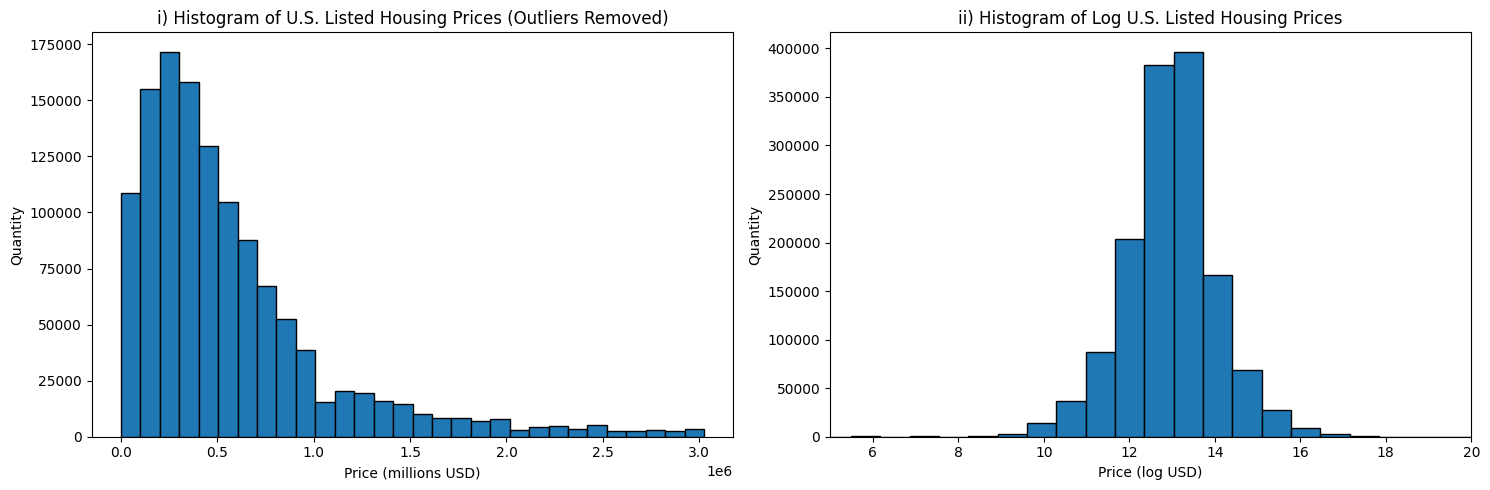

In [6]:
print('Figure 1: Price versus Log Price Distribution')

#Plotting data for price distribution
fig, fig_price = plt.subplots(1,2,figsize=(15,5))

fig_price[0].hist(data['price'],bins=30,edgecolor='black')
fig_price[0].set_title("i) Histogram of U.S. Listed Housing Prices (Outliers Removed)")
fig_price[0].set_ylabel("Quantity")
fig_price[0].set_xlabel("Price (millions USD)")

#Plotting data for log price distribution
fig_price[1].hist(df['log_price'],bins=30,edgecolor='black')
fig_price[1].set_title("ii) Histogram of Log U.S. Listed Housing Prices")
fig_price[1].set_ylabel("Quantity")
fig_price[1].set_xlabel("Price (log USD)")
fig_price[1].set_xlim(5,20)

plt.tight_layout()

Figure 1 is broken into two subfigures: 

F.1 i) depicts the distribution of variable ‘price’, clearly showing the positive skew identified within the summary statistics. This distribution is unimodal, with a clear peak at 250,000 USD. The distribution shows a clear change in slope at 1,000,000 USD, where the slope of the distribution decreases sharply. This is a point not seen in the ‘log_price’ data, and could become a point for grouping in the future. This distribution clearly shows the “bottom heavy” nature of the real estate market, where the majority of properties fall under the 1,000,000 USD mark. 

F.1 ii) presents as a unimodal, steep distribution with a peak of around 13. This is less intuitive than a value given by the ‘price’ distribution, but due to the symmetrical shape allows us to translate that the median of the data is around 440,000 USD, which matches the value we see in the summary statistics table. 

Both F.1 i) and F.1 ii) have their uses, but the distribution of only the Y-variable is insufficient to describe the entire dataset. 


Figure 2: Distribution of X-variables


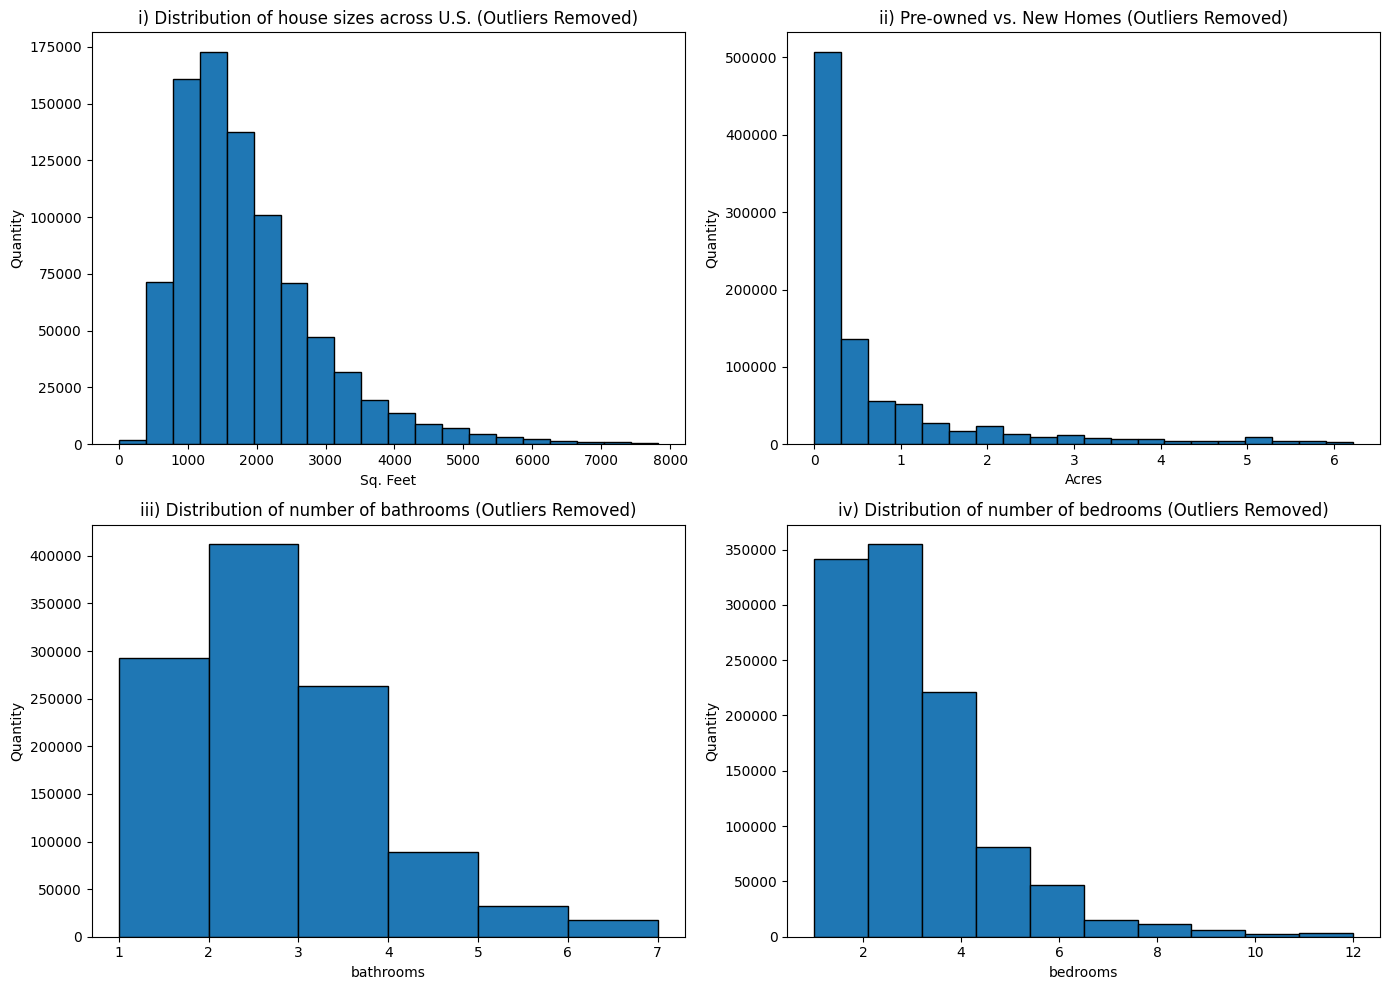

In [7]:
print('Figure 2: Distribution of X-variables')

def set_label(ax, title, x, y, a, b):
    ax[a,b].set_title(title)
    ax[a,b].set_xlabel(x)
    ax[a,b].set_ylabel(y)

fig, fig_1 = plt.subplots(2, 2, figsize=(14, 10))

fig_1[0,0].hist(data['house_size'], bins=20, edgecolor="black")
set_label(fig_1,'i) Distribution of house sizes across U.S. (Outliers Removed)','Sq. Feet','Quantity',0,0)

fig_1[0,1].hist(data['acre_lot'], bins=20, edgecolor='black')
set_label(fig_1,'ii) Pre-owned vs. New Homes (Outliers Removed)','Acres','Quantity',0,1)

fig_1[1,0].hist(data['bath'], bins=6, edgecolor="black")
set_label(fig_1,'iii) Distribution of number of bathrooms (Outliers Removed)','bathrooms','Quantity',1,0)

fig_1[1,1].hist(data['bed'], bins=10, edgecolor="black")
set_label(fig_1,'iv) Distribution of number of bedrooms (Outliers Removed)','bedrooms','Quantity',1,1)

plt.tight_layout()

Figure 2 again presents several subplots:

F.2 i) Shows the distribution of variable ‘house_size’. This distribution is similar to the house price distribution, hinting at a possible close correlation. Both unimodal and positively skewed, the most interesting finding being that very few homes are under 500 square feet. These homes typically represent studio apartments or sublet rooms, and are a lifeline for low-income consumers. The severe lack of these “micro-residences” may not be replicated in other countries, as the U.S. has traditionally strayed away from constructing properties of this nature. 

F.2 ii) Shows the distribution of the ‘acre_lot’ variable. This distribution shows visually the stark difference in property size between properties that was touched upon during analysis of the summary statistics. With the vast majority of homes holding less than 1 acre, the few properties holding large amounts of land, most of which are not pictured due to the removal of outliers, hold most of the land in the real estate market. 

F.2 iii) & F.2 iv) depict the distributions of the number of bathrooms and bedrooms respectively, and both share similar information. Both are unimodal and positively skewed, similar to all of the other distributions. The one difference between the two is the fact that homes tend to have less bathrooms than they do bedrooms. 

The fact that all four distributions look similar to each other and to the price distribution gives a hint at the possible correlation between each of them with the price variable. This is important for further research as having a strong correlation between these X-variables and the Y-variable will allow for easier isolation of the effects of walkability or other mobility data. The only X-variable not covered in these distributions is the ‘sold_before’ dummy variable, which will be better displayed in a pie chart. 


Figure 3: Distribution of Houses by Sold Before Status


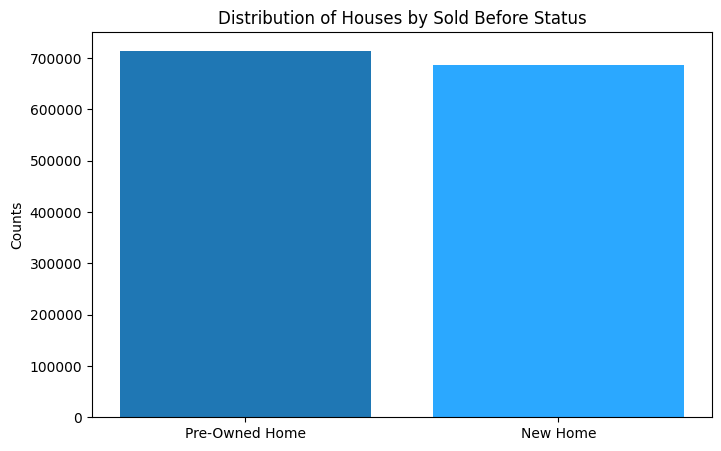

In [8]:
print('Figure 3: Distribution of Houses by Sold Before Status')
sold_counts = df['sold_before'].value_counts()

labels = ['Pre-Owned Home', 'New Home']
colors = ['#1f77b4', '#2ba8ff']

fig, ax = plt.subplots(figsize=(8, 5))
# Create bar plot
ax.bar(labels, sold_counts, color=colors)

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Distribution of Houses by Sold Before Status')
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)

plt.show()

Figure 3 clearly shows that while there are slightly more pre-owned homes than new homes, each represents essentially half of the data. This is good news for further research, as it means there is an abundance of data for both values of ‘sold_before’, allowing for conclusive results if they happen to present different trends when grouped separately. In combination with location and walkability data this would allow the ability to see if new developments were better or worse for walkability than their older counterparts, and where walkable developments are being constructed. 


Figure 4: Number of Entries for Each State</div>


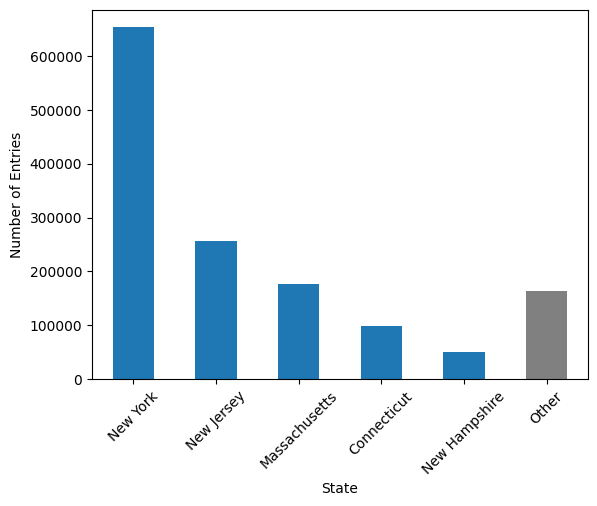

In [9]:
print('Figure 4: Number of Entries for Each State</div>')
data_by_state_vals = df['state'].value_counts()

top_5_states = data_by_state_vals.head(5)
other_states_sum = data_by_state_vals[5:].sum()

colors_bar = ['#1f77b4','#1f77b4','#1f77b4','#1f77b4','#1f77b4','Grey']

# Using pd.concat instead of append
top_5_and_other = pd.concat([top_5_states, pd.Series([other_states_sum], index=['Other'])])

# Plot
top_5_and_other.plot(kind='bar',color=colors_bar)
plt.xlabel('State')
plt.ylabel('Number of Entries')
plt.xticks(rotation=45)  # Rotate state names for better readability
plt.show()

Figure 4 shows a bar plot representing the quantity of data for each state within ‘df’. As shown, New York represents a large portion of the data, followed by New Jersey and Massachusetts. This has major implications for conclusions drawn by the paper. These states all represent the North-Eastern United States, and while that alone does not present a problem, it limits this paper’s ability to draw conclusions about the entire U.S., as the northeast differs drastically from the west coast or the south. The northeast also represents some of the wealthier areas of the U.S. meaning that our data and findings may be skewed towards the higher end of the price bracket. Although, because the northeastern states share many qualities, there might be stronger conclusions when only applying to the northeast. 

After finally establishing the dataset, it is time for initial mapping of X-variables to the Y-variable. This initial stage will not be conducted on variable ‘sold_before’ as its nature as a dummy variable prevents transferrable conclusions in the same way as the other X-variables. That is not to say that it cannot predict the Y-variable, just that it will be covered in further research.


Figure 5: Price Responses to X-Variables


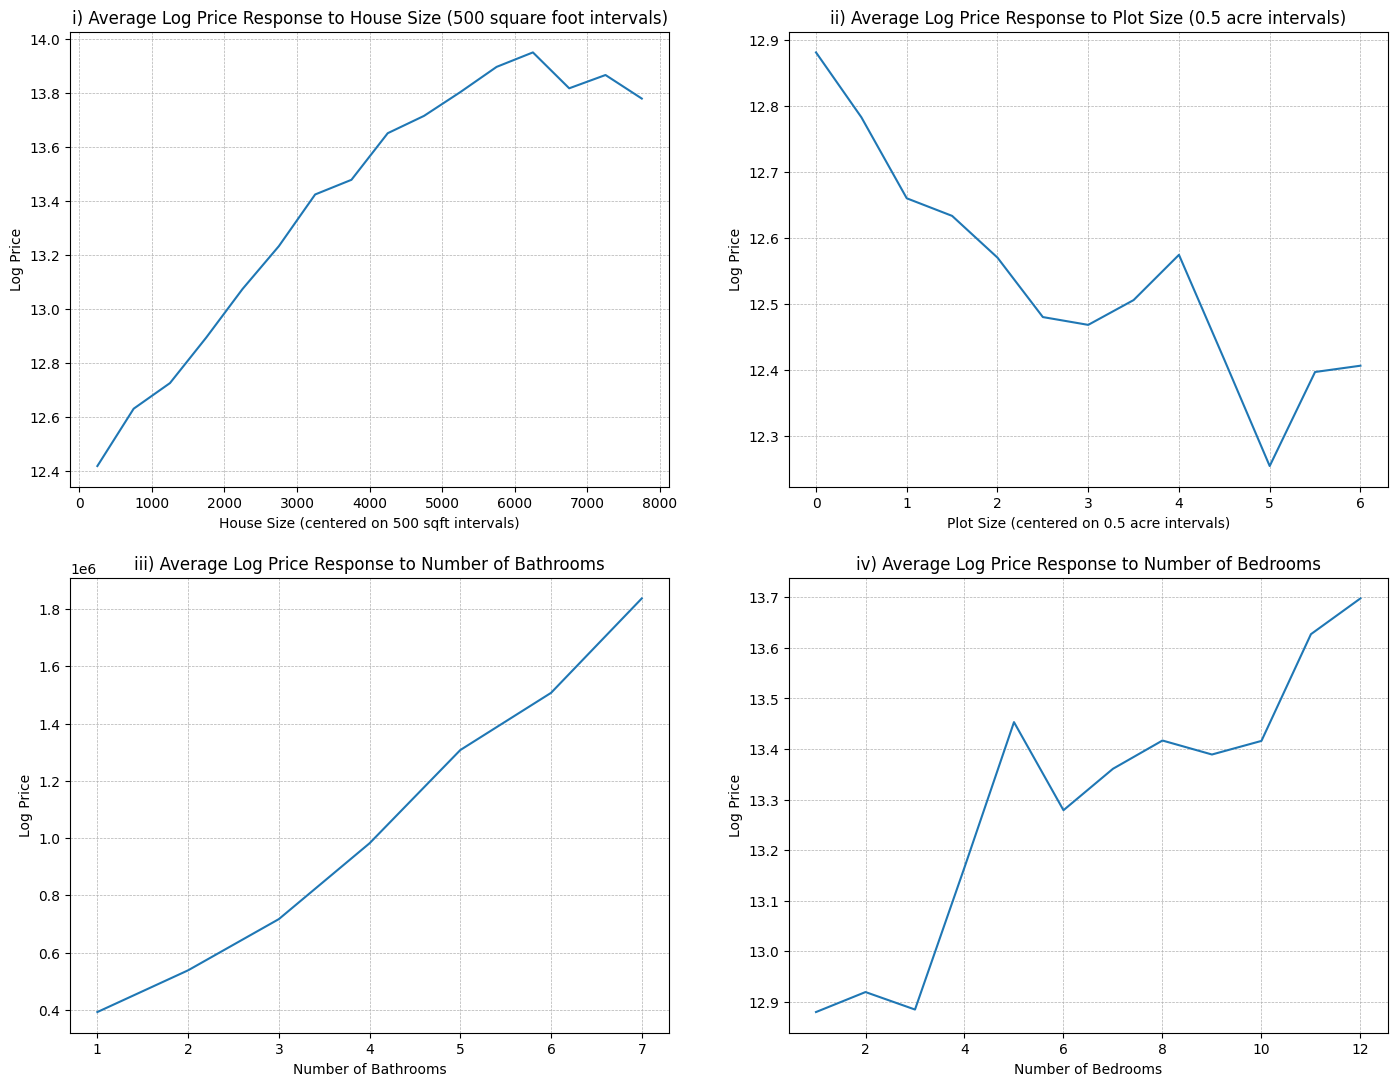

In [10]:
print('Figure 5: Price Responses to X-Variables')

data['house_size_interval'] = (data['house_size'] // 500) * 500 + 250
data['acre_interval'] = (data['acre_lot'] // 0.5) /2

# Initialize the figure
fig, ax = plt.subplots(2,2,figsize=(17, 13))

# Plot the average price for the entire dataset
overall_averages = data.groupby('house_size_interval')['log_price'].mean().reset_index()
ax[0,0].plot(overall_averages['house_size_interval'], overall_averages['log_price'], label='Overall')
set_label(ax,'i) Average Log Price Response to House Size (500 square foot intervals)',\
          'House Size (centered on 500 sqft intervals)','Log Price',0,0)
ax[0,0].grid(True, which='both', linestyle='--', linewidth=0.5)

overall_averages_acre = data.groupby('acre_interval')['log_price'].mean().reset_index()
ax[0,1].plot(overall_averages_acre['acre_interval'], overall_averages_acre['log_price'], label='Overall')
set_label(ax,'ii) Average Log Price Response to Plot Size (0.5 acre intervals)',\
          'Plot Size (centered on 0.5 acre intervals)','Log Price',0,1)
ax[0,1].grid(True, which='both', linestyle='--', linewidth=0.5)

overall_averages_bath = data.groupby('bath')['price'].mean().reset_index()
ax[1,0].plot(overall_averages_bath['bath'], overall_averages_bath['price'], label='Overall')
set_label(ax,'iii) Average Log Price Response to Number of Bathrooms','Number of Bathrooms','Log Price',1,0)
ax[1,0].grid(True, which='both', linestyle='--', linewidth=0.5)

overall_averages_bed = data.groupby('bed')['log_price'].mean().reset_index()
ax[1,1].plot(overall_averages_bed['bed'], overall_averages_bed['log_price'], label='Overall')
set_label(ax,'iv) Average Log Price Response to Number of Bedrooms','Number of Bedrooms','Log Price',1,1)
ax[1,1].grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

Figure 5 depicts 4 subplots, all of which show the average ‘log_price’ with respect to the X variable:

F.5 i) depicts the average ‘log_price’ response to each 500 square foot jump in ‘house_size’. This plot informs of the positive, weakly-linear relationship between house size and price. On average, the log price of a home increases rather consistently with an increase in home size. This conclusion is not surprising, as in the assumptions made when choosing house size as an X-variable, an increase in house size will cost money to build, increasing the sale price of the home. In terms of further research, this tells us that house size will be a strong predictor of home value.

F.5 ii) shows the average ‘log_price’ response to each 0.5 acre jump in ‘acre_lot’. This figure greatly contradicts the assumption made when acre_lot was chosen as an X-variable. As the plot size of a property increases, the value of the property actually decreases. This finding is so unintuitive that it is almost certainly linked to other factors. A possible explanation of this confusing finding can be drawn from the information from F.2 ii), that the vast majority of homes lie under the one acre mark. While the downward trend continues in this range, it makes sense that if the majority of properties lie within this group, there is a large chance that includes many high-value properties. This remains a highly interesting finding that will need to be both discussed and investigated further in future research. 

F.5 iii) depicts the average ‘log_price’ response to an increase in ‘bath’. This subfigure shows the closest to a linear correlation, with a slight decrease in slope after 5 bathrooms. Bathrooms are a necessity in every home, regardless of preference, and thus it reasons that a more expensive home will have more bathrooms. F.5 iii)’s findings almost perfectly match the assumption made when ‘bath’ was picked as an X-variable. In terms of future research, it may be interesting to view the importance of more bathrooms in an urban vs rural location, as perhaps more space-conscious urban residents value bathrooms differently than their rural counterparts. 

F.5 iv) represents the average ‘log_price’ response to an increase in ‘bed’. This subfigure has a very interesting shape compared to F.5 iii), contrary to the distributions which shared very similar qualities. F.5 iv) shows very sharp changes in average price for homes with different numbers of bedrooms, with the marginal value of an extra bedroom skyrocketing from 3 to 5. The strange changes in marginal log price presents an avenue for future research and discussion. Perhaps 5 bedrooms is the reasonable limit for urban residences?


# Project 2

## Merging With Another Dataset

While currently this dataset provides an immense amount of real-estate characteristics, it lacks the key variable required for the remainder of this paper: a walkability index. When deciding which walkability index to utilize, the U.S. Environmental Protection Agency (EPA)’s Smart Location Database was used. This database provides several benefits over other walkability indexes:

1. It is a public resource, allowing further research and ease of access
2. It has data down to the census block group level, allowing for precise conclusions
3. It is updated with every census, and thus presents the opportunity for analysis of change over time in the future

That being said, the combining with the Smart Location Database also has some flaws:

1. The census block groups do not perfectly match with the zip codes given in the original dataset
2. With the mapping level being quite high (zctas), mapping individual data points will not be effective at displaying general trends

This first code cell attempts to deal with problem number 1. 


In [11]:
#turning zips in realtor data into real zips
df_no_missing = df[df['zip_code'].notna()].copy()
df_no_missing['zip_code'] = df_no_missing['zip_code'].astype(int).astype(str).str.zfill(5)

#reading in the converter
zip_to_zcta_df = pd.read_csv("zip_zcta_xref.csv", dtype={'zip_code': str,'zcta': str})
z_z = zip_to_zcta_df.drop('source', axis = 'columns')
z_z['zip_code'] = z_z['zip_code'].astype(str)
z_z['zcta'] = z_z['zcta'].astype(str)

df_no_missing['zip_code'] = df_no_missing['zip_code'].str.strip()
z_z['zip_code'] = z_z['zip_code'].str.strip()

#adding zctas to dataset
df_z = pd.merge(df_no_missing,z_z,on = 'zip_code',how = 'left')
#df_z.head()

Table 3 displays the new dataset, utilizing zip_zcta_xref.csf (@JoeGermuska on GitHub), a crosswalk between USPS zip codes and Zip Code Tract Areas (ZCTAs). ZCTAs are a census group that allows zip codes to be used to analyze data on a nationwide scale. For the use of this project, the ZCTAs will allow for merging with the necessary walkability data. 

Each ZCTA is a 5 digit numerical string, often being exactly the same as the USPS postal code, and will be used for mapping later in the project. 


In [12]:
c_to_avg = ['bed','bath','acre_lot','house_size','sold_before','price','log_price','zcta']
d_selected = df_z[c_to_avg]

df_zcta_avg = d_selected.groupby('zcta').mean()
df_zcta_avg.reset_index(inplace=True)
#df_zcta_avg.head()

Now that the ZCTAs have been added to the dataframe, the second problem must be addressed. With so many data points, creating a map of all points will be messy and non-useful, thus, a new dataframe is created specifically for mapping named df_zcta_avg. This dataframe will be created by grouping the newly edited dataframe by ZCTAs, and then calculating the aggregate means for each column in each group. Then the index will be reset. This gives us a new dataframe with the average home characteristics within each ZCTA, a very useful tool for mapping. 

In [13]:
walkability = pd.read_csv("EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv", dtype={'COUNTYFP': str,'TRACTCE': str,'BLKGRPCE': str})
zcta_block = pd.read_csv('tab20_zcta520_tabblock20_natl.txt', sep = '|', header = 0, usecols=['GEOID_ZCTA5_20', 'GEOID_TABBLOCK_20'], dtype=str)

# Rename columns in the converter to match those in df for a consistent merge
zcta_block.rename(columns={'GEOID_ZCTA5_20': 'zcta','GEOID_TABBLOCK_20': 'block_group'}, inplace=True)
zcta_block.dropna(subset=['zcta'], inplace = True)
zcta_block['block_group'] = zcta_block['block_group'].str[:12]

def most_common_block_group(series):
    return series.mode()[0] 

# Group by 'zcta', and aggregate 'block_group' using the custom function
agg_df = zcta_block.groupby('zcta').agg({'block_group': most_common_block_group}).reset_index()

# Merge the DataFrames on 'zcta'
merged_df = pd.merge(df_zcta_avg, agg_df, on=['zcta'], how='left')
#merged_df.head()

#Prepare the walkability DataFrame by creating a FIPS code
walkability['block_group'] = walkability['STATEFP'].astype(str).str.zfill(2) + walkability['COUNTYFP'].astype(str).str.zfill(3) + walkability['TRACTCE'].astype(str).str.zfill(6) + walkability['BLKGRPCE'].astype(str)
walkability['block_group'] = walkability['block_group'].astype('Int64').astype(str)

conditions = [(walkability['D1B'] > 5)]
choices = ['Urban']

walkability['area_type'] = np.select(conditions, choices, default='Rural')

#Merge the new df with the walkability score based on block group
final_df = pd.merge(merged_df, walkability[['block_group', 'NatWalkInd','area_type', 'D3AAO', 'D4E', 'D1B', 'D5AR', 'TotEmp','Pct_AO0']], on='block_group', how='left')


#adding Walkscore back to the original df
df_z = df_z.merge(final_df[['zcta', 'NatWalkInd','area_type', 'D3AAO', 'D4E', 'D1B', 'D5AR', 'TotEmp','Pct_AO0']], on='zcta', how='left')


Once that aggregate data frame is created, the walkability data will be merged into the dataset. The walkability dataset only includes Census Block Groups as region parameters, and thus the relationship file taken from the U.S. Census website is used to convert ZCTAs into Census Block Groups to allow for merging.
	
This method inherently has some flaws, as ZCTAs are distinct from Census Block Groups, and thus some areas of overlap will be missing inherently. This presents an opportunity for further research, as a real-estate dataset that includes direct census measurement tools would allow for a more accurate picture of the real world. For now, this flawed method will have to do, as it is the only way to connect the walkability data to the real estate data. 

The final dataframe needed for mapping has 16 columns, and is now ready for mapping (ignoring shapefiles). This table displays the average characteristics of a home in each ZCTA, importantly, including walkability. A new column was also added, area_type, which is either “Rural” or “Urban”, and was categorized based on the U.S. Census definition of a population of over 5000 or over 2000 housing units. Note, the new dataframe we have created was merged onto our original data, so many of the census ZCTAs available in the Smart Location Database are now missing in maps that will be presented later. This is done to be consistent in presented information.

Now that a complete dataset has been created, a deep dive into the data is possible. 


## The Message

### THE MESSAGE ITSELF:
This paper shows that whether in an urban or rural/suburban community, walkability has an essentially linear relationship with home price, unlike the exponential relationships of other home characteristics. This means, assuming utility gain from walkability, something proven in other papers that this paper assumes, homeowner utility can be greatly increased at a far lower cost than other home characteristics. 


### Justification:

Figure 6: Average Log Price by Walkability Bin


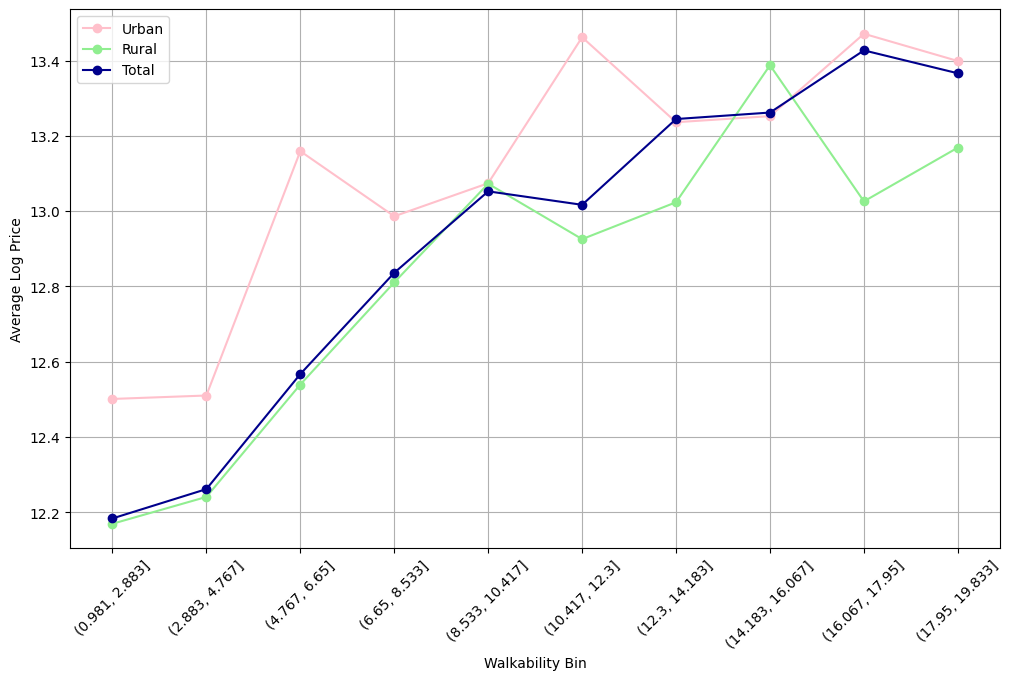

In [14]:
print('Figure 6: Average Log Price by Walkability Bin')
df_urb = df_z[df_z['area_type'] == 'Urban'].copy()
df_sub = df_z[df_z['area_type'] != 'Urban'].copy()
df_z['walkability_bin'] = pd.cut(df_z['NatWalkInd'], bins=10)

df_urb['walkability_bin'] = pd.cut(df_urb['NatWalkInd'], bins=10)
df_sub['walkability_bin'] = pd.cut(df_sub['NatWalkInd'], bins=10)

# Calculate the average log price for each bin for urban and rural
avg_log_price_per_bin = df_z.groupby('walkability_bin', observed=True)['log_price'].mean().reset_index()
avg_log_price_per_bin_urban = df_urb.groupby('walkability_bin', observed=True)['log_price'].mean().reset_index()
avg_log_price_per_bin_rural = df_sub.groupby('walkability_bin', observed=True)['log_price'].mean().reset_index()

plt.figure(figsize=(12, 7))

# Urban line
plt.plot(avg_log_price_per_bin['walkability_bin'].astype(str), avg_log_price_per_bin_urban['log_price'], marker='o', linestyle='-', color='pink', label='Urban')

# Rural line
plt.plot(avg_log_price_per_bin['walkability_bin'].astype(str), avg_log_price_per_bin_rural['log_price'], marker='o', linestyle='-', color='lightgreen', label='Rural')

# Total line
plt.plot(avg_log_price_per_bin['walkability_bin'].astype(str), avg_log_price_per_bin['log_price'], marker='o', linestyle='-', color='darkblue', label='Total')

plt.xlabel('Walkability Bin')
plt.ylabel('Average Log Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()  # This adds the legend to the plot

plt.show()

Improvements to walkable infrastructure have, in recent times, been wholly focused on urban areas. This follows from the assumption that those who live in urban cores care more about walkability, and that urban areas are often already somewhat walkable. This paper argues that this goes against the data. When plotted earlier in the paper, housing characteristics like number of bathrooms and bedrooms presented a linear correlation with log_price, meaning an exponential correlation with price. Figure 6 shows that walkability is unique in the fact that it displays a diminishing positive correlation with log price, meaning it holds a roughly linear correlation with home price. 

The reason this linear relationship is interesting is due to three things: 

1. People are willing to pay a premium for homes that are located in more walkable neighborhoods, but isolating that effect to just walkability may be hard
2. Unlike bedrooms or bathrooms, walkability is a ‘shared’ characteristic of a home, meaning that the cost of walkability is spread out among all those who live in a walkable neighborhood
3. People can live in very walkable societies without having to have drastic increases in the price of their home. 


The home often represents the single largest purchase of many Americans lives, and often makes up a significant portion of its owner’s financial assets, thus any factor able to change the amount one is willing to pay for a home is vital to understand. If walkability is a factor that can greatly increase the quality of one’s life, a statistic proven by many papers in the health and planning fields, and it can do so without having a severe impact on the price of one’s home, it presents an amazing opportunity for increased social utility without forcing home prices too high. Another insight of figure 6 is that both the urban and rural lines closely resemble the total line, meaning that these conclusions hold true for both urban environments, where most walkable infrastructure projects are currently being created, and rural environments, which are in dire need of walkable neighborhoods. 
Something to notice about Figure 6 is that the line for rural areas is slightly steeper than for urban areas. This is a very interesting finding, and will be elaborated on in future iterations of this project. 
Now that a relationship has been established between walkability and log price, we can visualize these relationships through mapping. 



## Maps and Interpretations

Figure 7: New York City Log Price and Walkability Index Maps


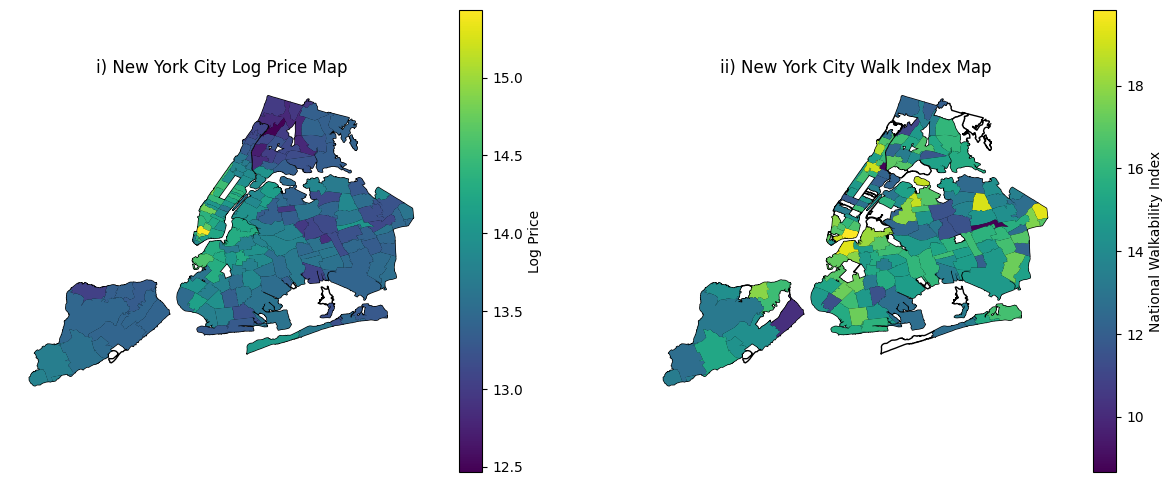

In [15]:
print('Figure 7: New York City Log Price and Walkability Index Maps')
nyc_df = pd.read_csv('Modified_Zip_Code_Tabulation_Areas__MODZCTA__20240229.csv', dtype = {'MODZCTA': str})
nyc_df.rename(columns={'the_geom': 'geometry', 'MODZCTA': 'zcta'}, inplace=True)
nyc_df['geometry'] = nyc_df['geometry'].apply(wkt.loads)
nyc_df = gpd.GeoDataFrame(nyc_df, geometry='geometry')

nyc_df_1 = pd.merge(nyc_df,merged_df,on = 'zcta', how = 'left')
nyc_df_2 = pd.merge(nyc_df,final_df,on = 'zcta', how = 'left')

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1
nyc_df.plot(ax=ax[0], color='white', edgecolor='black')
nyc_df_1.plot(column='log_price', ax=ax[0], legend=False, cmap='viridis')
ax[0].set_title("i) New York City Log Price Map")
ax[0].axis('off')

# Create a colorbar for the first plot
sm = ScalarMappable(norm=Normalize(vmin=nyc_df_1['log_price'].min(), vmax=nyc_df_1['log_price'].max()), cmap='viridis')
sm._A = []  # This is a workaround for missing array attribute error
cbar = fig.colorbar(sm, ax=ax[0])
cbar.set_label('Log Price')

# Plot 2
nyc_df.plot(ax=ax[1], color='white', edgecolor='black')
nyc_df_2.plot(column='NatWalkInd', ax=ax[1], legend=False, cmap='viridis')
ax[1].set_title("ii) New York City Walk Index Map")
ax[1].axis('off')

# Create a colorbar for the second plot
sm = ScalarMappable(norm=Normalize(vmin=nyc_df_2['NatWalkInd'].min(), vmax=nyc_df_2['NatWalkInd'].max()), cmap='viridis')
sm._A = []  # This is a workaround for missing array attribute error
cbar = fig.colorbar(sm, ax=ax[1])
cbar.set_label('National Walkability Index')

plt.show()

F.7 i) displays the distribution of home prices in New York City. We can clearly see that New York has very expensive real estate, as much of the entire city is more expensive than the mean log(price) of 12.8 found in the data. This map also depicts clear zones of higher costs. The close you get to Manhattan, and the center of the city, the more expensive the homes become. 

F.7 ii) shows a similar trend to home prices, with much of the city being far above the mean walkability score. This plot also shows an increase in walkability the closer you get to Manhattan, visually depicting the correlation that was covered in the “Main Message” section. 

These two plots together allow the visualization of the correlation between walkability and log price. This reaffirms the conclusions drawn by Figure 6, and further demonstrates the increased demand that comes with walkability. Given that New York City serves as an outlier in both price and walkability numbers, it is reasonable to question its efficacy as a measure of their relationship, but drawing back to the conclusions of Figure 6, this relationship should hold regardless of urban vs rural setting.

This map also reveals another interesting conclusion, which is areas of New York City that may have undervalued real estate. Given the particular city in question this is unlikely, but there are several ZCTAs with very high walk scores and only slightly above average price. 

Given the relationship between log(price) and walkability has been displayed, the paper will now turn back to the urban vs rural distinction.


Figure 8: New York State Urban vs Rural Division


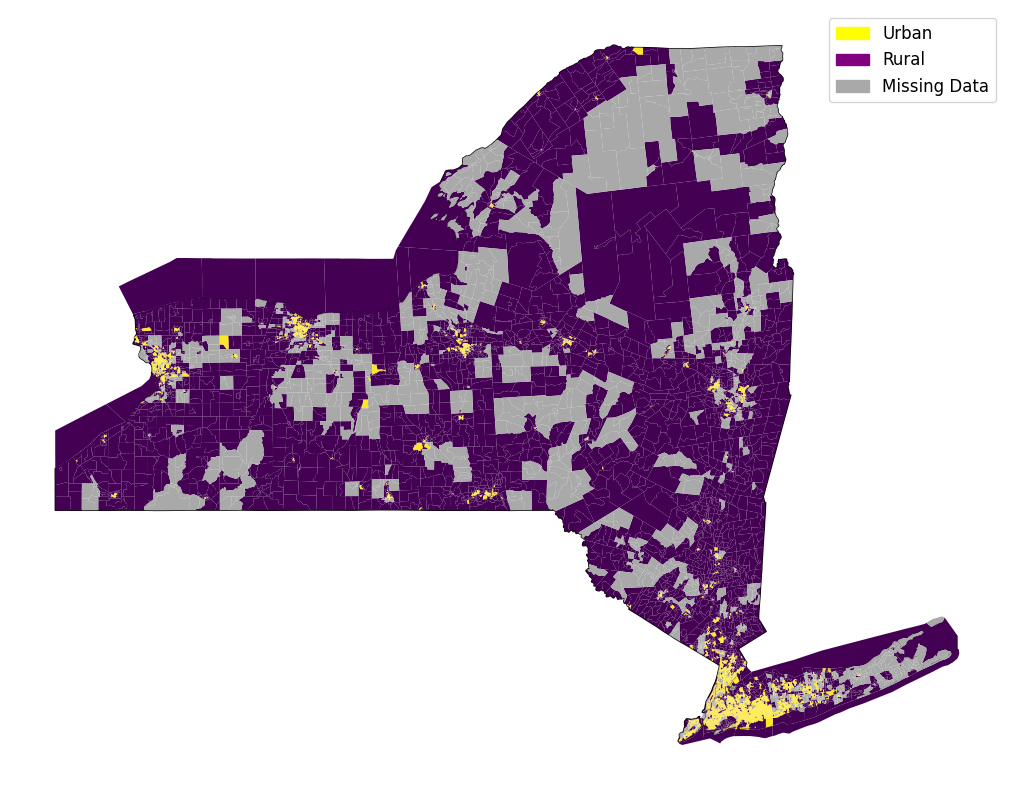

In [16]:
print('Figure 8: New York State Urban vs Rural Division')
ny_bg = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2021/BG/tl_2021_36_bg.zip", dtype={'COUNTYFP': str,'TRACTCE': str,'BLKGRPCE': str})

conditions = [(walkability['area_type'] == 'Urban')]
choices = [1]

walkability['a_type_num'] = np.select(conditions, choices, default=0)

state_df = gpd.read_file("http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_state_5m.zip")

ny_bg['block_group'] = ny_bg['STATEFP'].astype(str).str.zfill(2) + ny_bg['COUNTYFP'].astype(str).str.zfill(3) + ny_bg['TRACTCE'].astype(str).str.zfill(6) + ny_bg['BLKGRPCE'].astype(str)
ny_bg['block_group'] = ny_bg['block_group'].astype('Int64').astype(str)

merged_df_3 = pd.merge(ny_bg, walkability, on='block_group', how='left')

fig, gax = plt.subplots(figsize=(15, 10))

state_df[state_df["NAME"] == "New York"].plot(ax=gax, color="white", edgecolor="black")
merged_df_3.plot(ax=gax, column='a_type_num', legend=False, cmap='viridis', vmin=merged_df_3['a_type_num'].min(), vmax=merged_df_3['a_type_num'].max(), missing_kwds={'color': 'darkgrey', 'label': 'Missing values'})

urban_patch = mpatches.Patch(color='yellow', label='Urban')
rural_patch = mpatches.Patch(color='purple', label='Rural')
missing_patch = mpatches.Patch(color='darkgrey', label='Missing Data')
plt.legend(handles=[urban_patch, rural_patch, missing_patch], fontsize = 12)

plt.axis('off')
plt.show()

Figure 8 serves as a demonstration of urban vs suburban areas used in this paper. The definition used for urban was strict, with a required population density of over 5 residents/acre, but the goal was to compare metropolitan urban areas with suburbs/rural areas, and thus the strict definition is suitable. New York State was chosen due to being the state with the most data present in the dataset, though there is still significant missing data. The missing data obscures some of the information in the plot, but given most metropolitan centers were largely unaffected, conclusions drawn about urban areas remain strong.

This divide is severe, with the vast majority of the state being rural/suburban, and thus qualifying for the lower correlation between walkability and price. 


# Project 3

## Potential Data to Scrape

Given that walkability is a subjective term, defined differently depending on the intended use case, proving the reliability and integrity of the walkability metric used is vital in the acceptance of a paper’s conclusions. Within the current literature, the most commonly used metric for walkability is Walk Score. Walk Score™ is a walkability metric created for use in both research and commercial avenues, created by a private company. Given that many papers have already founded the reliability of Walk Score (Keskin, 2008), this paper will assume its reliability as a given. This is not to say that the National Walkability Index is unreliable, nor that the paper would cease to use it if Walk Score was used. Utilizing both metrics would allow a comparison of their predictive ability. A major benefit of Walk Score over the National Walkability Index is its ability to show Walk Score for the zip code level. This would prevent the need for the complicated process of converting the Census Block Groups found in the Smart Location Database to the zip codes found in the Realtor.com data, and thus remove possible errors introduced by this conversion. 

Walk Score data can be accessed through https://www.walkscore.com/, with the website including an API to assist in the scraping of data. Using this API the data can be directly converted into a dataframe object, where it would be merged onto the current dataframe to create a new variable “walk_score”. A left merge would be used, only taking entries found in the realtor.com data, as Walk Score includes data for all US zip codes.

## Potential Challenges

The largest problem with scraping from walkscore.com is the limit of 1000 api calls per day on their platform, and the fact that these free api calls can only be used for ‘free, user-facing’ purposes. For research, and higher quantities of api calls, an application must be made to the Walk Score company, or a costly membership must be purchased. Walk Score states on their website that they typically do not give access to undergraduate students, as the quantity of students requesting the data is too high. This process would also take a long time, as even with access to all of the data, calling the vast amount of data needed from the API would take longer than the time currently available (given the 1000 call limit per day, and the number of entries in the current df). To access this data for the future, an application would need to be created, perhaps after this current paper is complete, asking for permission to utilize the Walk Score data. This will probably have to occur at the postgraduate level, thus preventing further utilization of the data at the current stage of academia. 

While scraping of this website would be possible, and quite simple due to the api, the visualizations provided would add very little with a limit of 1000 observations. This is compounded by the presence of another walkability index already, meaning that any visualizations would probably be quite similar to the visualizations provided elsewhere in the paper showing the National Walkability Index. For this reason, this paper will scrape a table from WorldPopulationReview.com, that shows the average home cost and price growth in each state. This data is useful to visualize for the project, as the original realtor.com data is missing significant information about many states. 


## Scraping Data from a Website

In [17]:
web_url = 'https://worldpopulationreview.com/state-rankings/median-home-price-by-state'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

The first step in scraping the data from WorldPopulationReview.com is the creation of a url, and headers that will allow access to the website. This is done by linking the page url that includes that table that will be scraped, and headers found in the jupyter notebook provided for web scraping. 

This website does not have an API, so manual HTML scraping is necessary.


In [18]:
response = requests.get(web_url, headers=headers)

soup_object = BeautifulSoup(response.content)

data_table = soup_object.find('table', {'class': 'tp-table-body is-narrow w-full min-w-full table-auto border-separate border-spacing-0 border bg-white'})

all_values = data_table.find_all('tr')

data_web = []

Next, utilizing the get() function from requests, and the url and headers created before, the raw HTML data can be scraped, and converted to a Beautiful Soup object for ease of use. 

The table with the data is found under the HTML tag ‘table’, and class ‘tp-table-body is-narrow w-full min-w-full table-auto border-separate border-spacing-0 border bg-white’. These are used to find the data and create a data table. This datatable is then separated into the different ‘tr’ (table row) entries for looping. An empty list is then created. 


In [19]:
for tr in all_values[1:]:
    tds = tr.find_all(['th', 'td'])
    if len(tds) >= 3:
        state = tds[0].text.strip()
        value1 = tds[1].text.strip()
        value2 = tds[2].text.strip()
        # Add the extracted information to the data list
        data_web.append([state, value1, value2])
    else:
        # Handle rows that don't have enough <td>/<th> elements
        pass

state_median_prices = pd.DataFrame(data_web, columns=['State','med_price','price_growth'])


The next step is to loop through each table row in all_values, and separate the state, median house price, and average price growth into separate variables. These are then added into the data list, which is finally used to create a dataframe called state_median_prices. An if statement is included in the for loop in case any table rows are missing a value for any of the three variables. 

Now that the data is represented in a dataframe, it can be converted into a csv file. The code for this is left in a comment, as for the visualization within the paper, the data frame is used directly.


In [20]:
#top_companies_2023.to_csv('top_companies_2023.csv', index=False)

## Visualizing the Scraped Dataset

In [21]:
# Explicitly convert 'med_price' to string, then remove $ and , and convert to float
state_median_prices['med_price'] = state_median_prices['med_price'].astype(str).str.replace('$', '').str.replace(',', '')
state_median_prices['med_price'] = pd.to_numeric(state_median_prices['med_price'], errors='coerce')

# Explicitly convert 'price_growth' to string, then remove % and convert to float
state_median_prices['price_growth'] = state_median_prices['price_growth'].astype(str).str.replace('%', '')
state_median_prices['price_growth'] = pd.to_numeric(state_median_prices['price_growth'], errors='coerce')

Figure 9: Data From Webscraping


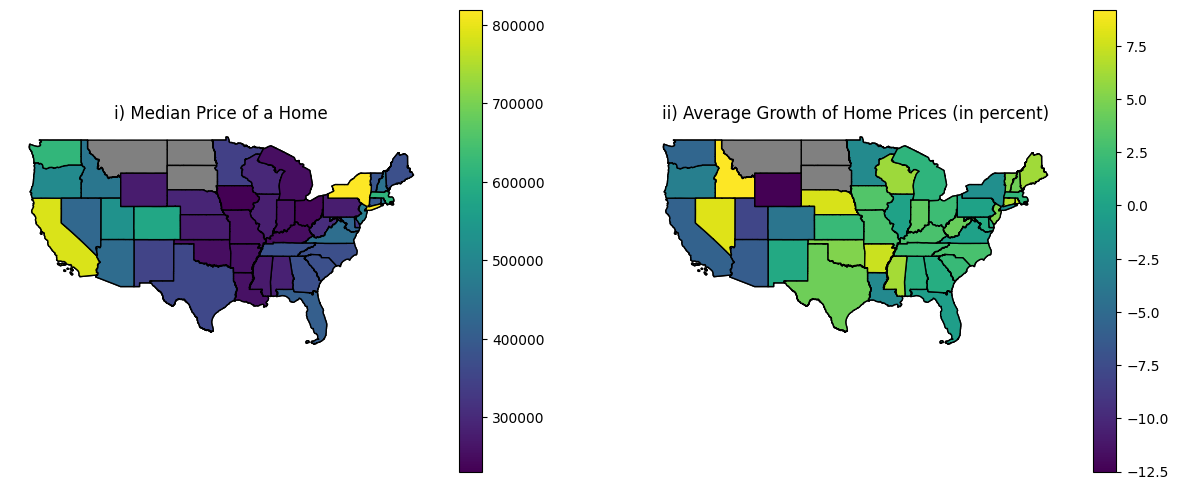

In [22]:
print('Figure 9: Data From Webscraping')
country_df = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2020/STATE/tl_2020_us_state.zip", dtype={'GEOID': str})

# Merge the median home price data with the country_df
country_df = pd.merge(country_df, state_median_prices, left_on='NAME', right_on='State', how='left')

mainland_geoids = [
    '01', '04', '05', '06', '08', '09', '10', '11', '12', '13', '16', '17', '18', '19', '20', 
    '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', 
    '36', '37', '38', '39', '40', '41', '42', '44', '45', '46', '47', '48', '49', '50', '51', 
    '53', '54', '55', '56'
]

# Filter the DataFrame to include only the mainland states by their GEOIDs
mainland_df = country_df[country_df['GEOID'].isin(mainland_geoids)].copy()

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Create a figure and a 1x2 grid of subplots
mainland_df.plot(ax=axes[0], color='gray', edgecolor='black')
mainland_df.plot(ax=axes[1], color='gray', edgecolor='black')

# Plot the median price map
mainland_df.plot(ax=axes[0], edgecolor="black", column='med_price', legend=True, cmap='viridis')
axes[0].set_title('i) Median Price of a Home')
axes[0].axis('off')

# Plot the price growth map
mainland_df.plot(ax=axes[1], edgecolor="black", column='price_growth', legend=True, cmap='viridis')
axes[1].set_title('ii) Average Growth of Home Prices (in percent)')
axes[1].axis('off')

plt.show()


Figure 9 i) depicts the average log home price for each state. This visualization was not possible with the original dataframe, as data was missing for many states. This data is missing information for a few states, but significantly less than the original data. This shows us the clear surplus of proximity to water, with homes in the midwest being worth significantly less than those on the west or east coasts. The two obvious outliers are New York State and California, who boast home prices significantly above the average (remember the scale is logarithmic so a small increase from 13.2 - 13.6 is quite large). 

Figure 9 ii) shows the same map for the average percentage growth in home price for each state. There are again, a couple of missing states. This visualization paints a far less clear picture.This depicts a far more even growth of home prices, with the states with lower prices seemingly having higher growth in price. This is interesting as it shows potential for growth in these ‘lower-value’ states, as home prices grow more rapidly in them. 



Figure 10: Scatter Plot of Data From Webscraping


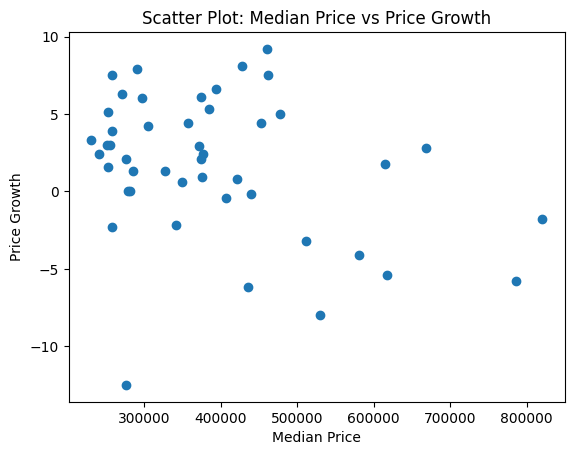

In [23]:
print('Figure 10: Scatter Plot of Data From Webscraping')
plt.scatter(mainland_df['med_price'], mainland_df['price_growth'])
plt.xlabel('Median Price')
plt.ylabel('Price Growth')
plt.title('Scatter Plot: Median Price vs Price Growth')
plt.show()


Figure 10 displays a scatter plot of the price growth variable vs the median price for each state. As touched upon in the analysis of figure 9 ii), there is a small, negative correlation between price growth and median price, meaning that, in states with higher home values, those home values grow slower. 

## Adding a New Dataset

In [24]:
poverty = pd.read_csv("ACSST5Y2020.S1701-Data.csv", usecols={'NAME','S1701_C03_001E','S1701_C03_002E'})
poverty = poverty.rename(columns={'S1701_C03_001E': 'total_below_pov', 'S1701_C03_002E': 'children_below_pov'})

poverty['NAME'] = poverty['NAME'].str.split(' ').str[1]

poverty = poverty.rename(columns={'NAME': 'zcta'})

df_data = pd.merge(df_z,poverty, on  = 'zcta', how = 'left')
df_data['total_below_pov'] = df_data['total_below_pov'].replace('-', np.nan)
df_data['children_below_pov'] = df_data['children_below_pov'].replace('-', np.nan)

# Convert columns to numeric, now that '-' has been replaced with NaN
df_data['total_below_pov'] = pd.to_numeric(df_data['total_below_pov'], errors='coerce')
df_data['children_below_pov'] = pd.to_numeric(df_data['children_below_pov'], errors='coerce')


Given that the purpose of this paper is to quantify the effect that walkability has on home price, the conclusions grow stronger as more home characteristics are accounted for. Currently, all home characteristics focus on physical traits of the home itself and the ZCTA surrounding it. To create a more complete picture, this paper will also include two important characteristics of the individuals residing within each ZCTA. When assessing the purchase of a home, people often consider their neighbors as much as they consider the home itself. The two variables used will be taken from the US census (specifically from data.census.gov). The two variables are:

-’S1701_C03_001E’ As ‘total_below_pov’

This variable gives the percentage of those residing within the ZCTA who qualify as ‘in poverty’. This metric allows the paper to ascertain the wealth status for each ZCTA, and include it in regressions.

-’S1701_C03_002E’ As ‘children_below_pov’

This variable allows the paper to assess the wealth status of children living within the ZCTA.

An understandable question about the inclusion of the two variables is “why include both when they both give almost the same data”. They are both included to calculate the difference between the two as a new variable, ‘pov_diff’. This variable takes into account a very important lurking determinant in home price, which is the wealth trend of a neighborhood. The wealth of older, often long-term residents of a neighborhood is often vastly different from younger, often shorter-term residents, and this difference may be a factor in determining the price of a home. When regressions begin, these three variables will not be regressed together, as they present as collinear, but this will be addressed once regression begins. 

Now that these variables have been added to the data, simple visualizations will be performed to give the readers an understanding of their distribution and scope. 


Figure 11: Histograms of Poverty Data


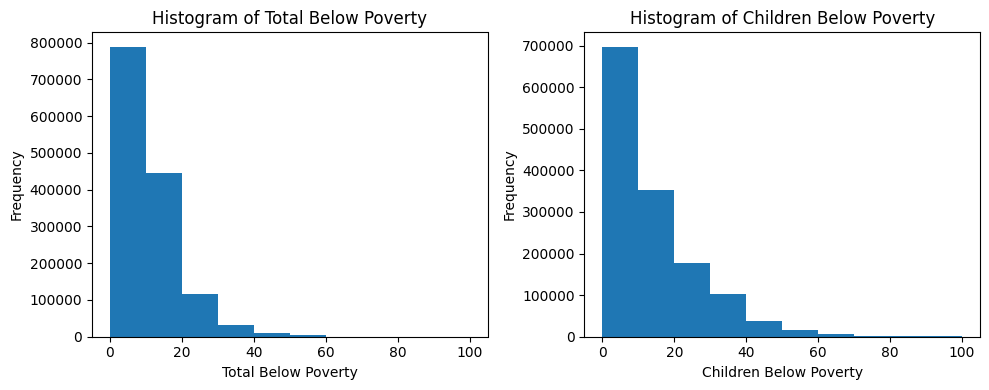

In [25]:
print('Figure 11: Histograms of Poverty Data')
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot histogram for "total_below_pov"
axes[0].hist(df_data['total_below_pov'], bins=10)
axes[0].set_xlabel('Total Below Poverty')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Total Below Poverty')

# Plot histogram for "children_below_pov"
axes[1].hist(df_data['children_below_pov'], bins=10)
axes[1].set_xlabel('Children Below Poverty')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Children Below Poverty')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


These histograms display the distribution of poverty rates throughout zctas in the data. These data display very similar trends to all other variables displayed through histograms, with strong positive skew. This tells us that most zctas in the data have low poverty rates, and that the distributions of total poverty and childhood poverty are very similar. One noticeable difference is that the child poverty statistics are slightly more spread out, with more zctas having above 20% childhood poverty than total poverty. 


In [26]:
poverty_avg = df_data[['total_below_pov','children_below_pov','zcta']].groupby('zcta').mean()

This dataframe is created to calculate the average statistic for 'total_below_pov' and 'children_below_pov' for each zcta

Figure 12: Poverty Rate and Children in Poverty Rate in New York City


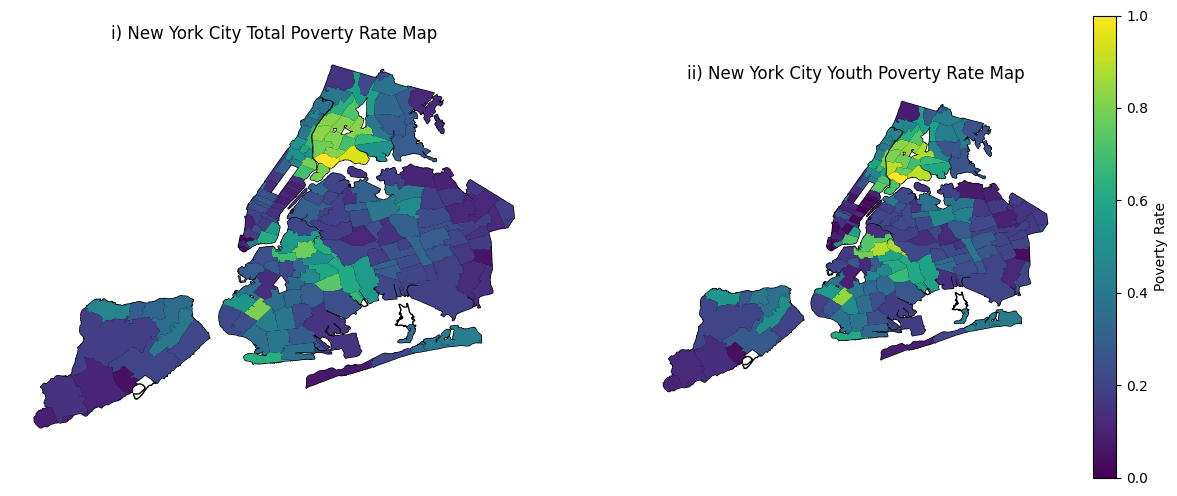

In [27]:
print('Figure 12: Poverty Rate and Children in Poverty Rate in New York City')

nyc_df_3 = pd.merge(nyc_df,poverty_avg,on = 'zcta', how = 'left')

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1
nyc_df.plot(ax=ax[0], color='white', edgecolor='black')
nyc_df_3.plot(column='total_below_pov', ax=ax[0], legend=False, cmap='viridis')
ax[0].set_title("i) New York City Total Poverty Rate Map")
ax[0].axis('off')

# Plot 2
nyc_df.plot(ax=ax[1], color='white', edgecolor='black')
nyc_df_3.plot(column='children_below_pov', ax=ax[1], legend=False, cmap='viridis')
ax[1].set_title("ii) New York City Youth Poverty Rate Map")
ax[1].axis('off')

# Create a colorbar for the second plot
sm = ScalarMappable(norm=Normalize(vmin=0, vmax=1))
sm._A = []  # This is a workaround for missing array attribute error
cbar = fig.colorbar(sm, ax=ax[1])
cbar.set_label('Poverty Rate')

plt.show()

These maps display the distribution of poverty rate and childhood poverty rate in New York City respectively. These maps are shown to contrast and compare with Figure 7. These two maps show that youth and total poverty are very closely related, and that both are very inversely related with home price and walkability. Zctas with high poverty rates show lower walkability scores and lower home values. This tells us that these two variables, or perhaps a variable created by combining both to account for covariance, will be an important regressor for future creation of a hedonic model. 

# Final Project

## OLS Regression

The visualizations in this paper display the roughly linear relationship between walkability and home price, and the non-linear relationship of price with all characteristics. Price shares this exponential relationship with all the variables present in the data. This relationship is due to the nature of the housing market and the wealth allocation in the world. With large amounts of wealth held at the top of the market, the consumer’s willingness to pay increases exponentially due to this exponential increase in available wealth. Homes are a necessary good and consumers are willing to pay a substantial proportion of their wealth, often greater than 100\% of their wealth, for a nice property. 

For regression, this paper utilizes the Ordinary Least Squares (OLS) method. This method creates a regression model that estimates $\beta$ values for each x-variable, along with the constant term, to minimize the Sum of Squared Errors term:

\[
\frac{1}{N} \sum_{i=1}^N \left(\log(\text{price}_i) - (\beta_0 + \beta_1 \text{x}_{1i} + \ldots + \beta_n \text{x}_{ni}) \right)^2
\]


This equation is the fundamental basis for the creation of all models shown in this section of the paper. 

The general form of regression equation will be:

\[
\widehat{log(price)}_i = \beta_0 + \beta_1 \ x_1 + \ldots + \beta_n \ x_n + \epsilon
\]

In [28]:
df_data['const'] = 1
df_data['urban'] = df_data['area_type'].apply(lambda x: 1 if x == 'Urban' else 0)
df_data['walk_urban'] = df_data['NatWalkInd'] * df_data['urban']

In [31]:
#create 4 models to test the effect of different variables on log price
x1 = ['const','NatWalkInd']
x2 = ['const','NatWalkInd','bed','bath','sold_before','acre_lot','house_size','urban']
x3 = ['const','bed','bath','sold_before','acre_lot','house_size','urban']

reg1 = sm.OLS(df_data['log_price'] * 100, df_data[x1], missing='drop').fit()
reg2 = sm.OLS(df_data['log_price']* 100, df_data[x2], missing='drop').fit()
reg3 = sm.OLS(df_data['log_price']* 100, df_data[x3], missing='drop').fit()


In [32]:
df_cleaned1 = df_data.dropna(subset=['const','NatWalkInd','bed','bath','sold_before','acre_lot','house_size','urban','log_price'])

influence1 = reg2.get_influence()

cook1 = influence1.cooks_distance

influential_points_1 = df_cleaned1.index[cook1[0] > 4*(np.mean(cook1[0]))]

df_no_cook = df_data.drop(influential_points_1)


In [33]:
# Add the interaction term to your list of independent variables
x5 = x2 + ['walk_urban']

# Fit the model with the interaction term
reg4 = sm.OLS(df_no_cook['log_price'] * 100, df_no_cook[x2], missing='drop').fit()
reg5 = sm.OLS(df_no_cook['log_price'] * 100, df_no_cook[x5], missing='drop').fit()

In [34]:
stargazer1 = Stargazer([reg1])
stargazer2 = Stargazer([reg2, reg3])
stargazer3 = Stargazer([reg4, reg5])

stargazer1.custom_columns(['Regression (1)'], [1])
stargazer2.custom_columns(['Regression (2)', 'Regression (3)'], [1,1])
stargazer3.custom_columns(['Regression (4)', 'Regression (5)'], [1,1])

stargazer1.show_model_numbers(False)
stargazer2.show_model_numbers(False)
stargazer3.show_model_numbers(False)

stargazer1
#print(stargazer1.render_latex())



\[
\hat{\log(\text{price}_i)} = \beta_0 + \beta_1\log(\text{walkability}_i)
\]

\textbf{Regression (1)} displays the simple regression of log price on the National Walkability index. This model displays the simple positive correlation shown elsewhere in the paper through visualizations. This model’s conclusions are limited to this extent, and even so, the estimated $\beta$ is far too high, as it must also account for every other home characteristic.

The $R^2$ value of 0.111 tells of significant variance that goes unexplained by walkability, which is completely understandable. An important number is the number of observations: 1050427, which will be compared to the observation counts of future regressions. Both the constant term and the NatWalkInd coefficient are statistically significant to all standard significance levels. 

In [35]:
stargazer2
#print(stargazer2.render_latex())


\begin{align*}
\widehat{\log(\text{{price}}_i)} =\ & \beta_0 + \beta_1 \text{{acre}}_i + \beta_2 \text{{bath}}_i + \beta_3 \text{{bed}}_i + \beta_4 \text{{size}}_i \\
& + \beta_5 \text{{walkability}}_i + \beta_6 \text{{sold\_before}}_i + \beta_7 \text{{urban}}_i + \epsilon_i
\end{align*}

\textbf{Regression (2)} Includes all physical characteristic variables, if the house has been sold before, as well as controlling for if the home is in an urban environment. The model concludes that after controlling for these variables, walkability remains positively correlated with home price. Returning to a hedonic analysis, this explains a positive utility in walkability after controlling for physical home characteristics. While other physical home characteristics are still missing, this positive marginal utility for home prices remains important economically. 

Before each coefficient can be interpreted: \textbf{acre}, and \textbf{size} have very small coefficients compared to other included variables. Remembering the units of these variables, an extra acre of land or 1 extra square foot will have minimal effect on home price, after controlling for all other variables. For this reason, in interpretations, the paper will consider an increase of 200 square feet instead of one square foot. 

This regression is useful due to its reliance on just physical home characteristics. This model predicts the value a consumer might place on a home just from its listing on a real estate website like Realtor.com. This is because these websites simply list the physical characteristics of a home, often with walkability included. This model is thus a model for a consumer who does not do due diligence in the selection of a home and simply decides value based on simple characteristics.

With an $R^2$ value of 0.273, this model is significantly more accurate than Regression (1), but much variance remains. That being said, the F statistic is still very large, and every variable included, except for urban, is significant to all conventional significance levels. The Urban coefficient is very interesting, as through common sense one would expect an urban home to be worth more than a non-urban one. Perhaps much of the marginal utility of an urban home is held within the walkability term, or in a physical characteristic difference between rural and urban homes.

This problem may be explained through the observation count, specifically the impact that acre has on the observations. Many urban homes are missing values for acre, meaning that non-urban properties are disproportionately considered in this regression. This is a major contributor to acre potentially not being included in the preferred specification, as it skews the data away from urban environments and removes a significant portion of the sample.

\begin{align*}
\widehat{\log(\text{{price}}_i)} =\ & \beta_0 + \beta_1 \text{acre}_i + \beta_2 \text{bath}_i + \beta_3 \text{bed}_i \\
& + \beta_4 \text{size}_i + \beta_5 \text{sold\_before}_i + \beta_6 \text{urban}_i + \epsilon_i
\end{align*}

\textbf{Regression (3)} considers the same variables as Regression (2), minus the walkability metric. 

This shows the impact that walkability has on the data, and proves its significance as a variable. Essentially every other variable changes significantly, showing that almost every other physical characteristic accounts for walkability in its value to home buyers and owners. This measure also represents, almost literally, the market on Realtor.com. This is because all listed variables (minus urban, which is intuitively listed through location), are listed on the listing for any particular property when viewed on the website. This means a simple post on the platform with no other information can estimate its listing values through this simple model. 

The urban coefficient is now much larger. This shows that much of the value of the ‘urban premium’ of a home is encompassed by walkability. This finding is immensely important, as it explains a very simple way to improve the value of homes in rural areas: increase walkability. 

All coefficients and the constant term remain statistically significant to all conventional significance levels.


In [36]:
stargazer3
#print(stargazer3.render_latex())


\begin{align*}
\widehat{\log(\text{{price}}_i)} =\ & \beta_0 + \beta_1 \text{acre}_i + \beta_2 \text{bath}_i + \beta_3 \text{bed}_i + \beta_4 \text{size}_i \\
& + \beta_5 \text{walkability}_i + \beta_6 \text{sold\_before}_i + \beta_7 \text{urban}_i + \epsilon_i
\end{align*}

\textbf{Regression (4)} is a copy of Regression (2), with points with very high cook value removed. Cook’s distance is defined as:

\[
{D}_i = \frac{{{e}_i}^2 }{{ps}^2}[\frac{{h}_{ii}}{(1-{h}_{ii})^2}]
\]

Where:
\textbf{${D}_i$} is the Cook’s Distance
\textbf{${e}_i$} is the squared residual
p is the rank of the model
\textbf{$s^2$} is the mean squared error
\textbf{${h}_{ii}$} is the leverage

Cook’s distance allows for the identification of entries that have a large pull on the regression. For Regression (4), this paper removes entries with Cook’s distance greater than 4 times the mean Cook’s distance in the data. This removes 208 entries from a model with almost 500,000 entries.

This simple removal of $frac{1}{2500}$ of the entries changes almost every coefficient in significant ways. This removal also brings the $R^2$ value from 0.277 to 0.425, a significant improvement without the addition of any new variables. This shows that these few properties were immense outliers compared to the rest of the data, and pulled the regression significantly. 

The removal of these outliers is an often controversial step, as these values with high Cook’s distance often represent interesting cases to examine. For this paper, which aims to construct a general model applicable to average homes, these severe outliers are only distractions from a more applicable model. These outliers represent properties in the data that a regular consumer will not purchase. These include a home listed with 100 bathrooms or 100 bedrooms. A comprehensive model may be able to utilize these data points, but a simple regression will over-value these outliers and thus paint a less accurate picture of the data that is actually relevant for this paper. 

\begin{align*}
\widehat{\log(\text{{price}}_i)} =\ & \beta_0 + \beta_1 \text{acre}_i + \beta_2 \text{bath}_i + \beta_3 \text{bed}_i + \beta_4 \text{size}_i + \beta_5 \text{walkability}_i \\
& + \beta_6 (\text{walkability} \times \text{urban})_i + \beta_7 \text{sold\_before}_i + \beta_8 \text{urban}_i + \epsilon_i
\end{align*}

\textbf{Regression (5)} shows the same regression as Regression (4), with an interaction term added for urban and log(walkability). This is done to account for the inherent link that walkability has with urban spaces, and thus for the change in slope that would accompany an urban environment. 

This even more depicts the large connection between urban environments and walkability. This explains some of the urban premium of homes as significantly related to the walkability benefits associated with living in an urban environment. The direct coefficients are no longer separately analyzable, but the fact that the interaction term had such a large impact on urban areas is still an interesting discovery. 

Now that all physical characteristics within the data have been regressed, the social characteristics must receive the same treatment. 

These regressions aim to analyze the connection that social characteristics of a neighborhood (or in this case zcta) have on the value of the homes in said neighborhood. 

In [37]:
x11 = ['const','total_below_pov','NatWalkInd', 'urban', 'walk_urban']
x12 = ['const','D3AAO', 'D1B', 'D5AR', 'NatWalkInd', 'urban','walk_urban','D4E']

reg11 = sm.OLS(df_data['log_price'], df_data[x11], missing='drop').fit()
reg12 = sm.OLS(df_data['log_price'], df_data[x12], missing='drop').fit()

In [38]:
stargazer7 = Stargazer([reg11, reg12])

stargazer7.custom_columns(['Regression (6)', 'Regression (7)'], [1, 1])
stargazer7.show_model_numbers(False)
stargazer7
#print(stargazer7.render_latex())


\begin{align*}
\widehat{\log(\text{{price}}_i)} =\ & \beta_0 + \beta_1\text{walkability}_i + \beta_2\text{total\_below\_pov}_i \\
& + \beta_3 \text{urban}_i + \beta_4 (\text{walkability} \times \text{urban})_i + \epsilon_i
\end{align*}

\textbf{Regression (6)} includes NatWalkInd, urban, its interaction term, and then also accounts for the poverty within the ZCTA where the home is located. Poverty plays an important role in the value of a home, as neighborhoods with higher poverty rates will house individuals who have less total income to pay for a home. Poverty is a vital social characteristic, and it displays a strong negative correlation with price. From current coefficients, a 1 percentage point increase in total poverty rate is correlated with a 2.9 percent decrease in home price after controlling for urban vs rural environments and walkability. This correlation is significant to all conventional significance levels, as are the coefficients on walkability, urban, and the interaction term. 

This regression quantifies the negative relationship that poverty has with home price, and through hedonic analysis shows that consumers' utility of purchasing a home goes down when more of their future neighbors fall below the poverty line. This could be due to a multitude of social issues that are not accounted for, but remain an interesting insight into the preferences of consumers. 

\begin{align*}
\widehat{\log(\text{{price}}_i)} =\ & \beta_0 + \beta_1\text{D1B}_i + \beta_2\ \text{D3AAO}_i + \beta_3 \text{D5AR}_i + \beta_4 \log(\text{D4E})_i \\
& + \beta_5 \text{walkability}_i + \beta_6 (\text{walkability} \times \text{urban})_i + \beta_7 \text{total\_below\_pov}_i \\
& + \beta_{8} \text{urban}_i + \epsilon_i
\end{align*}

\textbf{Regression (7)} shows the relationship that mobility and employment have, along with walkability, on home price. This regression depicts a positive correlation between all variables except for the walkability and urban relationship term. This negative relationship will be explored in further regressions but remains an interesting contrast to the positive relationship found on the same variable when only physical characteristics were included.

Economically it is interesting to see that including the network density, number of jobs, and population size has a measurable impact on the coefficients for both NatWalkInd and urban. This implies that some of the consumer value placed in walkability and an urban environment is encompassed by these social characteristics. This justifies these characteristics holding a spot in the preferred specification. Again, all coefficients are significant to all conventional levels. 


In [39]:
x6 = ['const','D3AAO', 'D1B', 'D5AR', 'TotEmp','Pct_AO0', 'total_below_pov', 'children_below_pov', 'NatWalkInd', 'urban', 'walk_urban', 'D4E', 'log_price']
x7 = ['const','D3AAO', 'D1B', 'D5AR', 'TotEmp','Pct_AO0', 'total_below_pov', 'children_below_pov', 'NatWalkInd', 'urban','walk_urban','D4E']

reg6 = sm.OLS(df_data['log_price'] * 100, df_data[x7], missing='drop').fit()

In [40]:
df_cleaned2 = df_data.dropna(subset=x6)

influence2 = reg6.get_influence()

cook2 = influence2.cooks_distance

influential_points_2 = df_cleaned2.index[cook2[0] > 4*(np.mean(cook2[0]))]

df_no_cook2 = df_cleaned2.drop(influential_points_2)

In [41]:
reg7 = sm.OLS(df_no_cook2['log_price']*100, df_no_cook2[x7], missing='drop').fit()

In [42]:
stargazer4 = Stargazer([reg6, reg7])

stargazer4.custom_columns(['Regression (8)', 'Regression (9)'], [1, 1])
stargazer4.show_model_numbers(False)
stargazer4
#print(stargazer4.render_latex())


\begin{align*}
\widehat{\log(\text{{price}}_i)} =\ &\beta_0 + \beta_1\text{D1B}_i + \beta_2\ \text{D3AAO}_i + \beta_3\text{D4E}_i + \beta_4 \text{D5AR}_i + \beta_5 \log(\text{Pct\_AO0})_i \\
& + \beta_6 \text{TotEmp}_i +  \beta_7 \text{children\_below\_pov}_i + \beta_8 \text{walkability}_i \\
& + \beta_9 (\text{walkability} \times \text{urban})_i + \beta_{10} \text{total\_below\_pov}_i + \beta_{11} \text{urban}_i + \epsilon_i
\end{align*}

\textbf{Regression (8)} depicts a model that considers all available social characteristics of the ZCTA surrounding a home. An immediate point to acknowledge is the significantly lower $R^2$ compared to Regression (5). This has two possible causes: that physical characteristics matter more in a consumer’s mind than social characteristics when determining the value they are willing to pay for a home, or that this dataset does not include major social characteristics that have a large impact on the price of a home. Both theories are very plausible, and likely both contribute to this lower $R^2$ value. 

Turning to the coefficients the walk\_urban coefficient is now negative compared to the positive relationship found in Regression (5). Regression (5)s positive coefficient implies that walkability matters more for urban homes than rural ones, whereas Regression (8)s negative coefficient implies that walkability matters more for rural homes. This difference is quite important, as determining which population group cares more for walkability is a major, policy influencing statistic. This relationship will have to be returned to once both physical and social characteristics are accounted for. 

The coefficients on the social characteristics are more visible now that the predicted log price has been multiplied by 100. This allows a clear view of the negative relationship that poverty shares with home price, and the positive relationship that the other included social characteristics have with home price. Interestingly, maybe by pure coincidence, the coefficient on NatWalkInd is very similar in Regression (5) and Regression (8). Again all coefficients are significant to all conventional significance levels. 

\begin{align*}
\widehat{\log(\text{{price}}_i)} =\ &\beta_0 + \beta_1\text{D1B}_i + \beta_2\ \text{D3AAO}_i + \beta_3\text{D4E}_i + \beta_4 \text{D5AR}_i + \beta_5 \log(\text{Pct\_AO0})_i \\
& + \beta_6 \text{TotEmp}_i +  \beta_7 \text{children\_below\_pov}_i + \beta_8 \text{walkability}_i \\
& + \beta_9 (\text{walkability} \times \text{urban})_i + \beta_{10} \text{total\_below\_pov}_i + \beta_{11} \text{urban}_i + \epsilon_i
\end{align*}

\textbf{Regression (9)} is Regression (8) with the Cook’s distance outliers removed. Regression 9 removes around 10,000 observations, significantly more than were removed when calculating Cook’s distance outliers for regressions (4) and (5). Proportionally this impact is still small, as regressions (8) and (9) include roughly 1000000 entries. The removal of these Cook’s distance outliers has a significantly smaller impact on the $R^2$ values for the social characteristics than for the physical characteristics. This implies that the data includes more physical outliers than social ones, and that said physical outliers have a stronger pull on the regression than the social outliers. This makes intuitive sense for many of the social characteristics which tend to even themselves out on a ZCTA level. One strange builder can construct and list a home with 100 bathrooms, but having strange observations on a ZCTA level requires hundreds if not thousands of coincidences. Because of this, regression (8) is in reality more comprehensive than regression (9), regardless of the slightly lower $R^2$ value. Social outliers hold weight for a reason, whereas physical ones do not.  

Now that a comprehensive analysis has been completed of regressions involving both social and physical characteristics of a home separately, an analysis of both physical and social characteristics together can be completed. 

The following regression (10) is the preferred regression, and its objective function is as follows:


\begin{align*}
\min \frac{1}{N} \sum_{i=1}^N \biggl(&\log(\text{{price}}_i) - \bigl(\beta_0 + \beta_1 \text{{D1B}}_i + \beta_2 \text{{D3AAO}}_i + \beta_3 \text{{D4E}}_i + \beta_4 \text{{D5AR}}_i + \beta_5 \log(\text{{Pct\_AO0}})_i \\
& + \beta_6 \text{{TotEmp}}_i + \beta_7 \text{{acre}}_i + \beta_8 \text{{bath}}_i + \beta_9 \text{{bed}}_i + \beta_{10} \text{{children\_below\_pov}}_i \\
& + \beta_{11} \text{{size}}_i + \beta_{12} \text{{walkability}}_i + \beta_{13} (\text{{walkability}} \times \text{{urban}}_i) +  \beta_{14} \text{{sold\_before}}_i \\
& + \beta_{15} \text{{total\_below\_pov}}_i + \beta_{16} \text{{urban}}_i + \beta_{17} (\text{{urban}} \times \text{{acre}}_i) \bigr) \biggr)^2
\end{align*}


In [43]:
x9 = ['const','bed','bath','sold_before','acre_lot','house_size','D3AAO','D4E', 'D1B', 'D5AR', 'TotEmp','Pct_AO0', 'total_below_pov', 'children_below_pov', 'NatWalkInd', 'urban', 'walk_urban','urban_acre']

df_data['urban_acre'] = df_data['urban']*df_data['acre_lot']

reg8 = sm.OLS(df_data['log_price'] * 100, df_data[x9], missing='drop').fit()

In [44]:
df_cleaned3 = df_data.dropna(subset=['const','bed','bath','sold_before','acre_lot','house_size','D3AAO','D4E', 'D1B', 'D5AR', 'TotEmp','Pct_AO0', 'total_below_pov', 'children_below_pov', 'NatWalkInd', 'urban', 'walk_urban','log_price'])

influence3 = reg8.get_influence()

cook3 = influence3.cooks_distance

influential_points_3 = df_cleaned3.index[cook3[0] > 4*(np.mean(cook3[0]))]

df_no_cook3 = df_cleaned3.drop(influential_points_3)

In [45]:
x10 = ['const','bed','bath','sold_before','house_size','D3AAO','D4E', 'D1B', 'D5AR', 'TotEmp','Pct_AO0', 'total_below_pov', 'children_below_pov', 'NatWalkInd', 'urban', 'walk_urban']
reg9 = sm.OLS(df_no_cook3['log_price']*100, df_no_cook3[x9], missing='drop').fit()
reg10 = sm.OLS(df_data['log_price']*100, df_data[x9], missing='drop').fit()

In [46]:
stargazer5 = Stargazer([reg9,reg10])
stargazer5.custom_columns(['Regression (10)', 'Regression (11)'], [1, 1])
stargazer5.show_model_numbers(False)

stargazer5
#print(stargazer5.render_latex())


\begin{align*}
\widehat{\log(\text{{price}}_i)} =\ &\beta_0 + \beta_1 \text{{D1B}}_i + \beta_2 \text{{D3AAO}}_i + \beta_3 \text{{D4E}}_i + \beta_4 \text{{D5AR}}_i + \beta_5 \log(\text{{Pct\_AO0}})_i \\
& + \beta_6 \text{{TotEmp}}_i + \beta_7 \text{{acre}}_i + \beta_8 \text{{bath}}_i + \beta_9 \text{{bed}}_i + \beta_{10} \text{{children\_below\_pov}}_i \\
& + \beta_{11} \text{{size}}_i + \beta_{12} \text{{walkability}}_i + \beta_{13} (\text{{walkability}} \times \text{{urban}}_i) +  \beta_{14} \text{{sold\_before}}_i \\
& + \beta_{15} \text{{total\_below\_pov}}_i + \beta_{16} \text{{urban}}_i + \beta_{17} (\text{{urban}} \times \text{{acre}}_i) + \epsilon_i
\end{align*}

\textbf{Regression (10)} presents with the highest $R^2$ value, and considers the greatest number of variables. This is what it reveals about each variable’s effect on home price:

Gross population density has a positive relationship with home prices. This means consumers prefer to live in denser areas, after controlling for all other variables.
The density of intersections has a negative impact on home prices, showing that consumers prefer to live in places that have less automobile-focused infrastructure, after controlling for all other variables.
The frequency of transit service per capita has a positive relationship with home price, which shows that consumers prefer to live in locations with more transit service, after controlling for all other variables.
Consumers have a positive preference for jobs within a 45-minute radius, after controlling for all other variables.
The number of car-free households has a positive relationship with home value, after controlling for all other variables. This relationship can not be proven to be statistically significant to the 10th percent, once Cook outliers are removed. This relationship also gets significantly weaker when the Cook outliers are removed.
Consumers prefer to live in neighborhoods with higher employment, once controlling for all other variables. This possibly confirms the assumption that individuals prefer to be closer to businesses.
Acreage has a negative relationship with price once controlling for other variables. This may be due to other, uncontrolled variables like distance from urban areas, or age of property. Many large acreage properties are also not listed on traditional real estate websites like Realtor.com, so more data will be needed to make significant claims about rural acreage relationships. 
The number of bathrooms has a positive relationship with price when controlling for all other variables. Consumers prefer more bathrooms, regardless of other characteristics.
The number of bedrooms has a negative relationship with home price once controlling for all other variables and removing Cook outliers. This shows several things: that the cook outliers have an immense effect on this specific variable. By removing them the sign of the relationship flips completely. This also shows that increasing the number of bedrooms without increasing other variables decreases the value of a home. 
Consumers prefer to live in areas with lower rates of childhood poverty, after controlling for all other variables.
Consumers prefer to live in larger houses, after controlling for all other variables.
Walkability and urban environments are linked very closely, with the value of either being heavily associated with the other. The urban term is only significant to the 5th percent.
Acreage is less important to urban residents than to suburban residents. This intuitively could be caused by the shifting of value to other home characteristics. Land is very expensive in urban areas, and thus represents a lower value-per-dollar investment than other characteristics.

Analyzing the significance of this preferred model displays an $R^2$ of 0.566. This is the highest value of any performed regressions. This result may be skewed due to the higher number of variables, but the adjusted $R^2$ remains at 0.566 due to the large sample size. The final sample size for this regression is 492761. This value is significantly lower than the entire dataset, but similar to the number for regressions (2) - (5). 

\textbf{Regression (11)} is regression 10 with the Cook’s distance outliers not removed. Because of this, there are 198 fewer observations. For the removal of these 198 observations, the $R^2$ value increases significantly, and nearly all coefficients are different. This implies that these 198 observations were truly extreme outliers and thus are not beneficial in an analysis of ‘normal’ real estate purchases. 


## Machine Learning

These regressions have shown a clear positive correlation between walkability and home price, even after controlling for all other variables present in the data. This finding of correlation shows that the utility of consumers may be higher for homes with higher walkability (with causation not proven a definitive statement cannot be made). Now that a strong correlation has been shown, measuring the importance of walkability in the value of a home would add significantly to this paper’s claims. To do this the paper will utilize a Random Forest model, which generates regression trees to minimize:

With random bins of x-variables selected for each tree. This random selection forces the tree to analyze using every variable, and thus through selection can determine the importance/strength of the correlation across variables. 

Before a random forest model will be run, a simple regression tree will be created. This regression tree will be of depth 4 to maintain readability. The regression tree is fitted to the equation:


\[
\min_{j,s} \left[  \sum_{i: x_{i,j} \leq s, x_i \in R1}
    (y_i - \hat{y}_{R1})^2 +  \sum_{i: x_{i,j} > s, x_i \in R2}
    (y_i - \hat{y}_{R2})^2 \right]
\]

For each step, the algorithm finds a value of a specific variable on which to split the data into two predictions of y-hat. This chosen value is the one that minimizes the mean squared error of the two predictions. This is then repeated until the maximum depth has been reached. In this case, the maximum depth is equal to 3. This is done to maintain readability in the results. Utilizing such a low depth means the Mean Squared Error will be quite high, but utilizing more layers will result in a more cluttered visualization.

In [47]:
from sklearn import tree
from sklearn import metrics

In [48]:
df_no_missing_price = df_data.dropna(subset=['log_price'])
X = df_no_cook3.drop(columns=['price','log_price','prev_sold_date','area_type','status','city','state','walkability_bin','zcta','zip_code'])
for column in X:
    X[column] = X[column].astype('float')
y = df_no_cook3['log_price']

In [49]:
tree_1 = tree.DecisionTreeRegressor(max_depth=3).fit(X,y)

In [50]:
# use the fitted tree to predict
y_pred_tree = tree_1.predict(X)

# find the error of prediction (MSE)
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred_tree))

Mean Squared Error: 0.4060466181971944


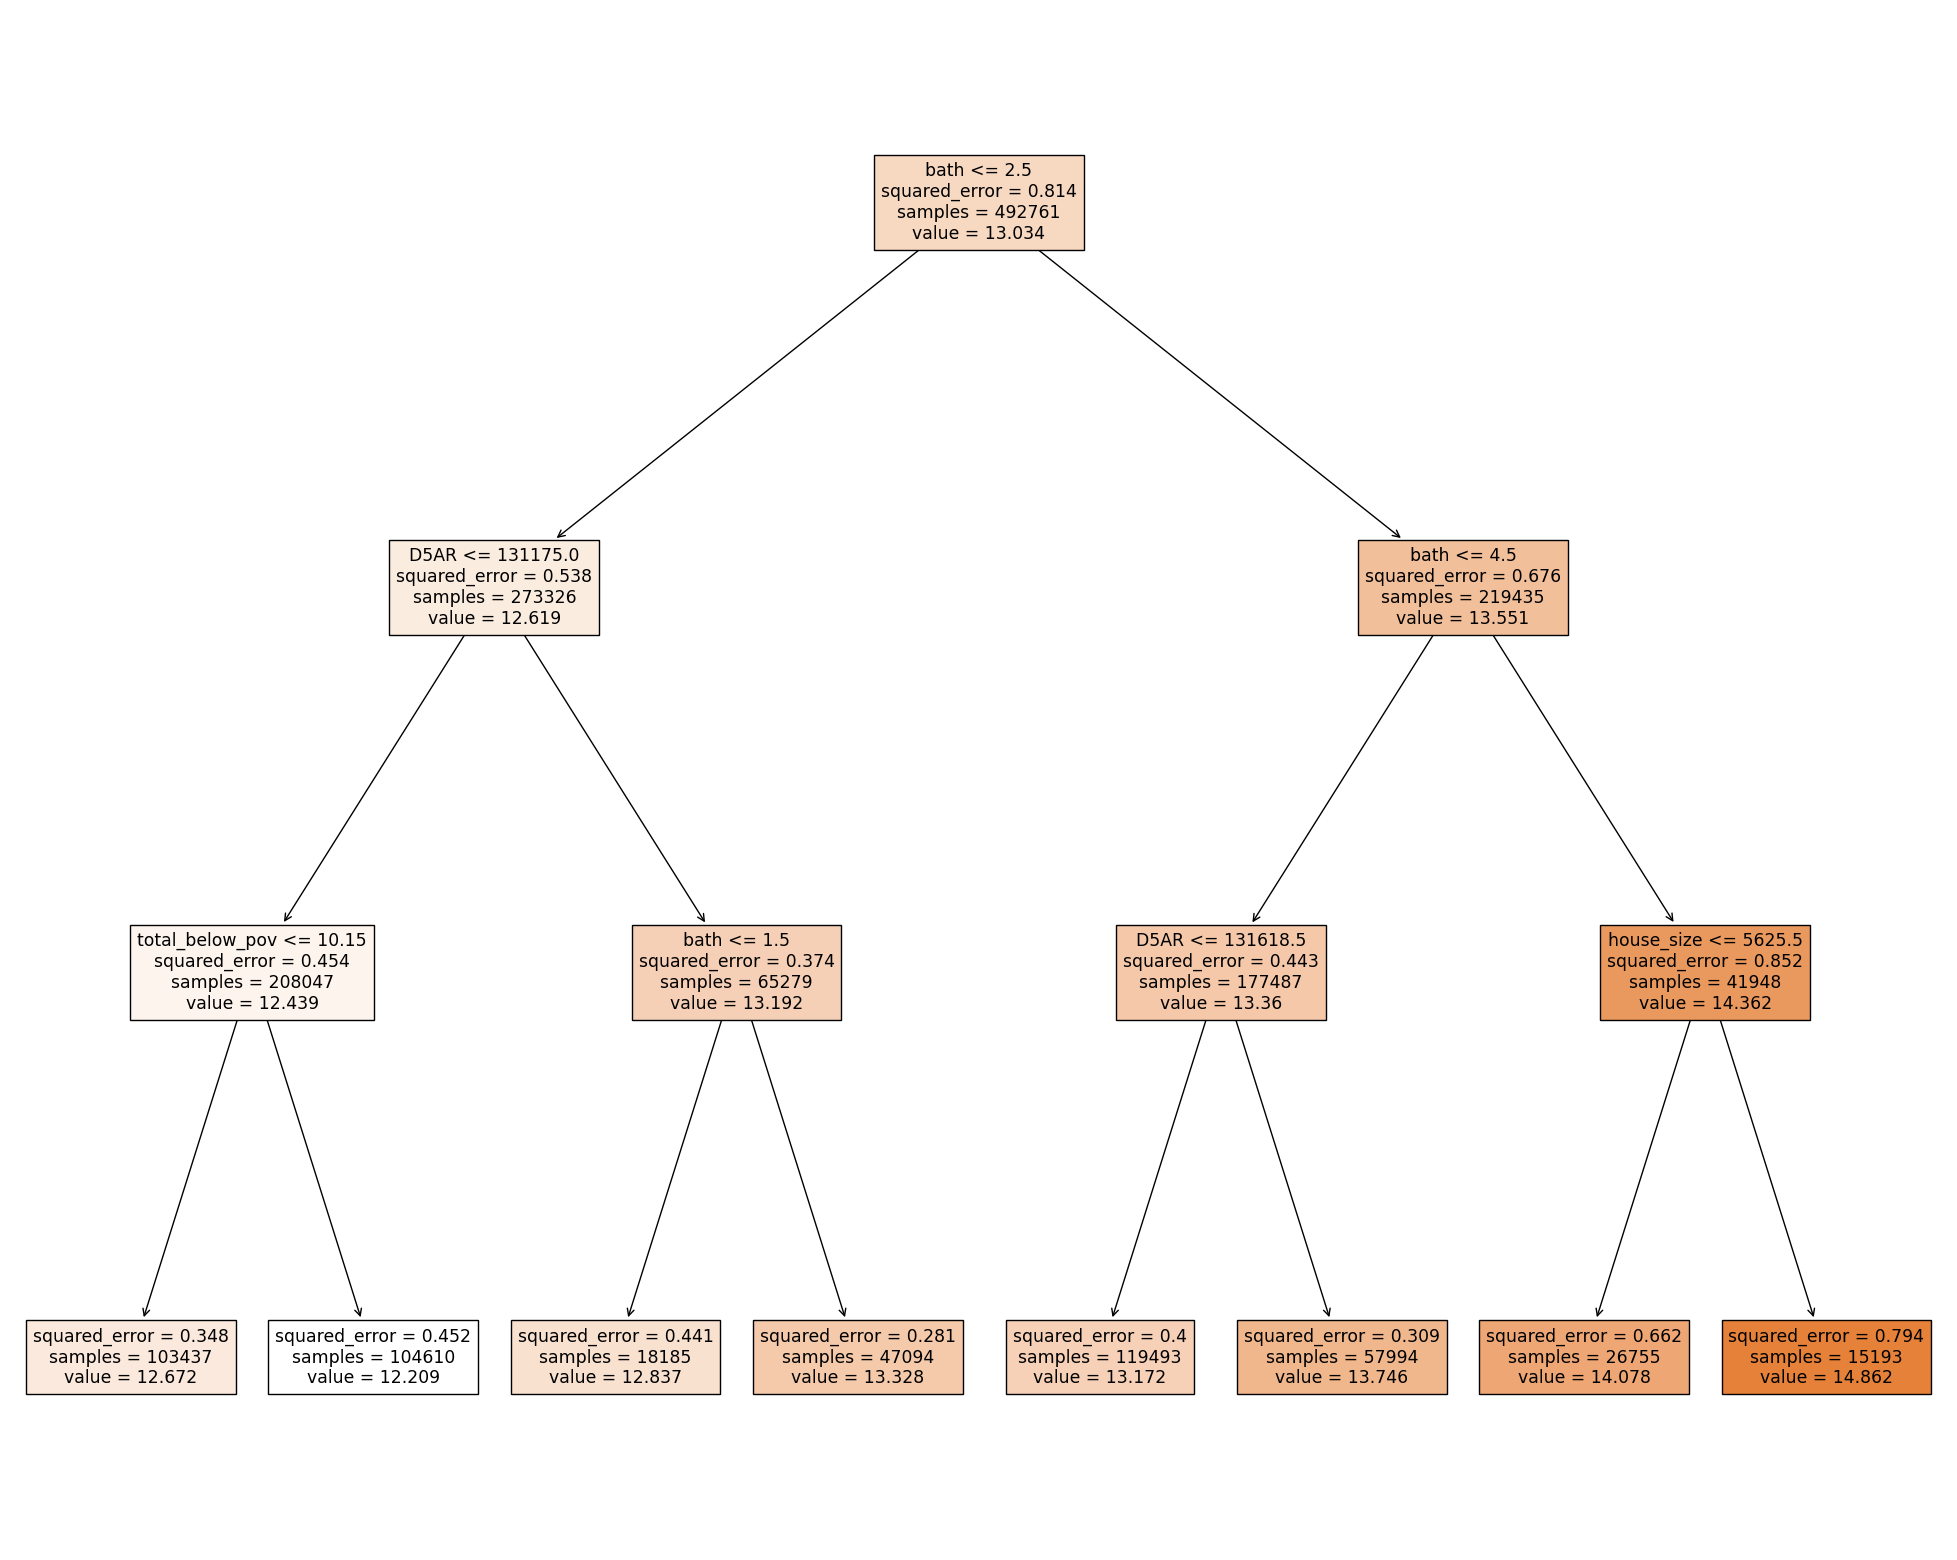

In [51]:
tree1_fig = plt.figure(figsize=(25,20))
tree1_fig = tree.plot_tree(tree_1, feature_names=X.columns, filled=True)

The Mean Square Error for this regression tree is 0.406, which is significant, and thus this simple tree does not do a very good job at predicting home value. This is completely understandable as only 3 layers are utilized. By creating a tree with, say 100 layers, a far more accurate picture can be painted. 

For this simple regression tree, the number of bathrooms in a home is by far the most used parameter. Several of the decision points for both expensive and cheaper homes are centered around the number of bathrooms, and that is not surprising for a tree with such limited depth. Bathrooms are something that essentially every home buyer values highly, and they are one of the two characteristics that are touted when giving the simplest possible description of a home (beds+baths). Along with bathrooms, frequency of transit service and acreage are used more than once. This means these variables likely have a high level of importance in predicting the value of a home. To test this importance, the random forest model will be run on the entire df\_data data frame. This will allow a visualization of the value of each variable on the price of a home. 

In [52]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report


A random forest model utilizes bagging techniques but forces the algorithm to utilize a limited set of variables for each tree. This forces the algorithm to fully interpret each variable and its importance in predicting the price of a home.

In [53]:
regr = RandomForestRegressor(max_features=5, random_state=1)
regr.fit(X, y)
pred = regr.predict(X)
mean_squared_error(y, pred)

0.000504823294587474

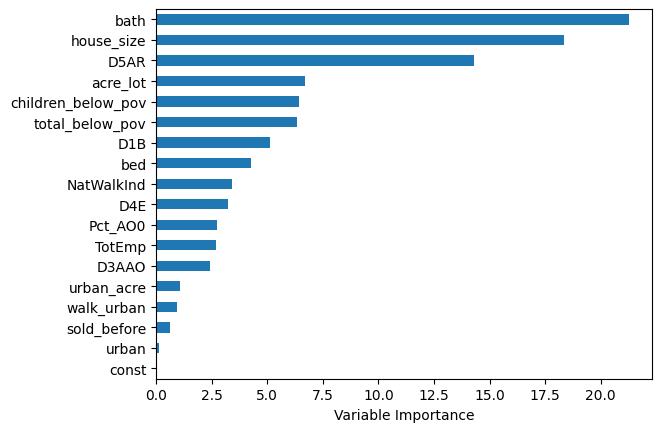

In [54]:
Importance = pd.DataFrame({'Importance':regr.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None


This random random forest model has an MSE of 0.0005048 which is very low. This means the model does a very good job predicting the value of a home when given all x-variable values.

This important plot shows that the most important variables in predicting the value of a home are the number of bathrooms, and the size of a home, the number of jobs within a 45-minute drive, and the size of the property. This makes both economic and numerical sense. Land is expensive, and construction is expensive. Constructing a larger home on larger land with a larger number of bathrooms will intuitively cost more money to a producer, and thus also a consumer. Jobs within a 45-minute drive are also intuitively important in the value of a home. By living close to their job any potential consumer can save hours of their day commuting. Interestingly, a social characteristic is so important in predicting the value of a home, but of any social characteristic D5AR makes the most sense. 
Given that this paper focuses on the link between walkability and home price, one would expect that the lower importance of the NatWalkInd variable would be detrimental, but the fact that they show a decent amount of importance, combined with the consistently positive relationship shown in regression allows a clear positive preference for walkable homes to emerge. 

This proof of importance is something that a regression cannot show or explain and is a major benefit of using models like a regression tree. The utilization of regression trees and the random forest model also allows for comparison across variables. Simple regressions give coefficients for each variable, allowing for individual comparison with price, something that regression trees do not, but those coefficients cannot be compared to each other. This makes ascertaining importance nearly impossible from a simple regression. Thus by utilizing both OLS regression and a random forest model, individual predictions as well as comparison of importance can both be discovered. 


## Conclusion


In its current form this paper serves as an introduction into the correlation between house prices and walkability. Through the utilization of simple plots, maps, regressions, and machine learning this paper has outlined the positive, nearly linear relationship between National Walkability Index scores and log(house prices). These conclusions, along with the proven benefits of walkability, combine into a useful resource for policymakers and developers alike (Yencha, 2019). In reality, these simple plots are missing significant information that could assist in the creation of a truly comprehensive report. Information about more states, and full information without many ZCTAs missing would allow for a more accurate picture to be painted. 

Further interpretations of the coefficients and the relationship as a whole are handicapped by the lack of causal relationship. This relationship may indeed exist, but in it's current form this paper fails to establish said relationship. 

Had a causal relationship been formally established, in combination with theory from (Rosen 1974), a true hedonic analysis of consumer preference for walkability could be established. In this hypothetical, consumers have a positive utility for walkability, regardless if they are urban or rural residents, and accounting for the social and physical characteristics of their home. But why does establishing this positive preference matter?

Walkability remains an interesting variable when modeling house prices, as consumers do not directly shop for a ‘walkable’ neighborhood. Instead, consumers consider walkability in the back of their minds, and clearly, it has an impact on the value of a property. Measuring the exact amount that walkability affects real estate prices is a task too heavy for the tools available in this iteration of the project, but said prediction would be of immense benefit to real estate professionals and academics alike. Because of this, modeling of home price to walkability will continue, and this paper will serve to strengthen the already strong academic base in support of a correlation between walkability and home price. 

Figuring out ‘why’ walkability matters so much to the value of a home is a separate question, more on the social research side than data analysis. This paper presents several theories.

The opportunity cost of purchasing a walkable home is greater than the surplus payment for the walkability. 

This theory posits that the cost involved in living in a non-walkable home is greater than the premium paid for a walkable location. This intuitively makes sense, as those who live in walkable neighborhoods often do not need to purchase or maintain things that someone in a non-walkable neighborhood would. A simple example is an automobile, which often makes up a significant cost for those who need them. This cost can be almost entirely erased by living in a location where an automobile is not necessary. Realtors and sellers know that the customer’s willingness to pay is significantly higher, as they are willing to divert funds from an automobile budget to their home. 

High walkability increases quality of life, to the extent that home buyers are willing to pay more for a walkable home.

Similar to other home characteristics, this theory proposes a quality of life increase associated with increased walkability. This is often thought of as the primary driver for physical home characteristics. People are willing to pay more for a house with three bathrooms than two, because an extra bathroom provides a quality of life improvement. If this theory is true, it makes drawing conclusions about the marginal utility of walkability significantly easier, as it can be thought of as a similar product to bedrooms, bathrooms, and other simple characteristics. 

Walkability comes as a status symbol, that individuals are willing to pay a premium for.

This theory again draws similarities between other home characteristics and walkability. An intuitive example of this theory is that a home near Central Park in New York City is probably worth more than a home in another part of the city that is less walkable, even if the resident does not intend on riding public transport or doing much walking. Walkability may be linked with status, either intentionally or by coincidence. 

These three theories do not entirely encompass the social literature on walkability, which in itself is an entire discipline of academia. In reality, walkability’s cost premium is likely created by a combined force of all three theories, along with additional factors not touched upon within this paper. 

While this paper currently serves as an in depth introduction into the relationship between walkability and home price, adding further analysis will only strengthen this resource. Utilizing regressions will allow for a more in-depth analysis of the direct connection between walkability and home price, as well as creation of a hedonic model, able to represent the utility of a home based on its characteristics (Keskin, 2008).

### References:

Chapman, J., Fox, E.H., Bachman, W., Frank, L.D., Thomas, J., Reyes, A.R. (2021). Smart Location Database Technical Documentation And User Guide, Version 3.0.

Guo, Yuntao, Srinivas Peeta, and Sekhar Somenahalli. 2017. The impact of walkable environment on single-family residential property values. Journal of Transport and Land Use 10 (1): 241-61.

Keskin, Berna. 2008. Hedonic analysis of price in the istanbul housing market. International Journal of Strategic Property Management 12 (2): 125-38, https://doi.org/10.3846/1648-715X.2008.12.125-138.

Kim, Eun Jung, and Hyunjung Kim. 2020. Neighborhood walkability and housing prices: A correlation study. Sustainability 12 (2): 593.

Li, Wei, Kenneth Joh, Chanam Lee, Jun-Hyun Kim, Han Park, and Ayoung Woo. 2015. Assessing benefits of neighborhood walkability to single-family property values. Journal of Planning Education and Research 35 (4): 471-88, https://doi.org/10.1177/0739456X15591055.

Pivo, Gary, and Jeffrey D. Fisher. 2011. The walkability premium in commercial real estate investments. Real Estate Economics 39 (2): 185-219.

Rauterkus, Stephanie Yates, and Norman Miller. 2011. Residential land values and walkability. Journal of Sustainable Real Estate 3 (1): 23-43.

Rosen, Sherwin. 1974. Hedonic prices and implicit markets: Product differentiation in pure competition. Journal of Political Economy 82 (1): 34-55.

Yencha, Christopher. 2019. Valuing walkability: New evidence from computer vision methods. Transportation Research.Part A, Policy and Practice 130 : 689-709.




In [55]:
def additional_stats(data_fr,x9):
    additional_st ={
    'Mode': data_fr[x9].mode().iloc[0],
    'Variance': data_fr[x9].var(),
    'Skewness': data_fr[x9].skew(),
    'Kurtosis': data_fr[x9].kurtosis()
    }
    return(additional_st)

In [56]:
xxx = ['D3AAO','D4E','NatWalkInd','Pct_AO0']

df_sum = df_data[xxx]

summary_stats2 = pd.concat([df_sum[xxx].describe(), pd.DataFrame(additional_stats(df_sum,xxx)).T])

print(summary_stats2.to_latex())

\begin{tabular}{lrrrr}
\toprule
 & D3AAO & D4E & NatWalkInd & Pct_AO0 \\
\midrule
count & 1050539.000000 & 1050539.000000 & 1050539.000000 & 1050539.000000 \\
mean & 3.298889 & -34307.297035 & 10.921800 & 0.149587 \\
std & 7.435937 & 47475.016851 & 4.721813 & 0.214205 \\
min & 0.000000 & -99999.000000 & 1.000000 & 0.000000 \\
25% & 0.000000 & -99999.000000 & 6.666667 & 0.016827 \\
50% & 0.275743 & 0.001803 & 11.666667 & 0.054902 \\
75% & 2.463157 & 0.020413 & 15.000000 & 0.178030 \\
max & 78.516389 & 181.443333 & 19.833333 & 0.929070 \\
Mode & 0.000000 & -99999.000000 & 14.666667 & 0.000000 \\
Variance & 55.293158 & 2253877224.993741 & 22.295514 & 0.045884 \\
Skewness & 3.886131 & -0.661018 & -0.094249 & 1.895224 \\
Kurtosis & 21.242701 & -1.563057 & -1.282228 & 2.799754 \\
\bottomrule
\end{tabular}

